In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
from training_utils import iterative_pruning
from training_utils import initializer

Set Seeds

In [6]:
import tensorflow as tf

In [7]:
seed = 7531
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
import matplotlib

In [9]:
np.where(np.linspace(-0.3,0.3,1001) == 0)

(array([500]),)

In [10]:
gnbu_b = plt.get_cmap("GnBu")(np.linspace(-0.3,0.3,1001))
gnbu_b[500,:] = np.array([0.,0.,0.,1.])
cmap = matplotlib.colors.ListedColormap(gnbu_b)

### Tensorflow

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

Masking: https://stackoverflow.com/questions/38278965/selectively-zero-weights-in-tensorflow

In [12]:
import tensorflow_datasets as tfds

In [13]:
(ds_train_mnist, ds_test_mnist), ds_info_mnist = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [14]:
ds_train_mnist_sm, ds_info_mnist_sm = tfds.load(
    'mnist',
    split=tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [15]:
(ds_train_fash, ds_test_fash), ds_info_fash = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [16]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #print(image.shape)
    print(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]).shape)
    print(tf.one_hot(label,10).shape)
    return tf.cast(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]), tf.float32) / 255., tf.one_hot(label,10)

def prep_data(ds, ds_info):
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds
#ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
#ds_train = ds_train.batch(128)
#ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_test = ds_test.cache()
#ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
#ds_test = ds_test.batch(128)
#ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
ds_train_mnist = prep_data(ds_train_mnist, ds_info_mnist)
ds_test_mnist = prep_data(ds_test_mnist, ds_info_mnist)

ds_train_fash = prep_data(ds_train_fash, ds_info_fash)
ds_test_fash = prep_data(ds_test_fash, ds_info_fash)

ds_train_mnist_sm = prep_data(ds_train_mnist_sm, ds_info_mnist_sm)

(784,)
(10,)
(784,)
(10,)
(784,)
(10,)
(784,)
(10,)
(784,)
(10,)


In [18]:
from custom_nn import Linear, FCN, FCN_Mask

In [19]:
def get_input_dim(ds):
    return iter(ds).next()[0].shape[1]
def get_batch_size(ds):
    return iter(ds).next()[0].shape[0]

In [20]:
input_dim = get_input_dim(ds_train_mnist)
batch_size = get_batch_size(ds_train_mnist)

In [21]:
input_dim

784

In [22]:
def just_eval(model, ds_test, supermask=False):
    eval_acc = tf.keras.metrics.CategoricalAccuracy()
    eval_loss_mean = tf.keras.metrics.Mean()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    for x_batch_test, y_batch_test in ds_test:
        if supermask:
            eval_pred, _ = model(x_batch_test)
        else:
            eval_pred = model(x_batch_test)
        eval_loss = loss_fn(y_batch_test, eval_pred)

        eval_loss_mean(eval_loss)
        eval_acc(y_batch_test, eval_pred)

    print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
    print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

## Baseline

In [276]:
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
fcn = FCN(input_dim, layer_shapes=LAYER_SHAPES)

In [273]:
init = initializer()

initializer


In [168]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-3 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn, initial_weights = init.set_weights_man(fcn, mode="uniform", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False)

Glorot uniform with bound 0.0033
Glorot uniform with bound 0.0100
Glorot uniform with bound 0.1000


In [169]:
def just_train(model, ds_train, epochs=6):
    optimizer = tf.keras.optimizers.Adam(1.2e-3) #tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    gradient_history = []
    layerwise_output_all = []
    
    for epoch in range(epochs):
    
        #print(f"Start of epoch {epoch}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted, layerwise_output = model(x_batch_train)
                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)


            grads = tape.gradient(loss, model.trainable_weights)
            gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)
            acc_metric(y_batch_train,predicted)
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())

        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
    
    return loss_history, acc_history, layerwise_output_all, gradient_history #model, 

In [170]:
loss_history, acc_history, output_history, gradient_history = just_train(fcn, ds_train_fash, epochs=60)

End of Epoch: 1: Accuracy = 0.777100 --- Mean Loss = 0.615824
End of Epoch: 2: Accuracy = 0.815475 --- Mean Loss = 0.512990
End of Epoch: 3: Accuracy = 0.832817 --- Mean Loss = 0.463355
End of Epoch: 4: Accuracy = 0.843862 --- Mean Loss = 0.431557
End of Epoch: 5: Accuracy = 0.852080 --- Mean Loss = 0.408032
End of Epoch: 6: Accuracy = 0.858083 --- Mean Loss = 0.390087
End of Epoch: 7: Accuracy = 0.863421 --- Mean Loss = 0.374835
End of Epoch: 8: Accuracy = 0.867854 --- Mean Loss = 0.362049
End of Epoch: 9: Accuracy = 0.871554 --- Mean Loss = 0.350913
End of Epoch: 10: Accuracy = 0.875058 --- Mean Loss = 0.340934
End of Epoch: 11: Accuracy = 0.878250 --- Mean Loss = 0.331842
End of Epoch: 12: Accuracy = 0.881083 --- Mean Loss = 0.323496
End of Epoch: 13: Accuracy = 0.883760 --- Mean Loss = 0.315849
End of Epoch: 14: Accuracy = 0.886232 --- Mean Loss = 0.308831
End of Epoch: 15: Accuracy = 0.888657 --- Mean Loss = 0.301985
End of Epoch: 16: Accuracy = 0.890765 --- Mean Loss = 0.295898
E

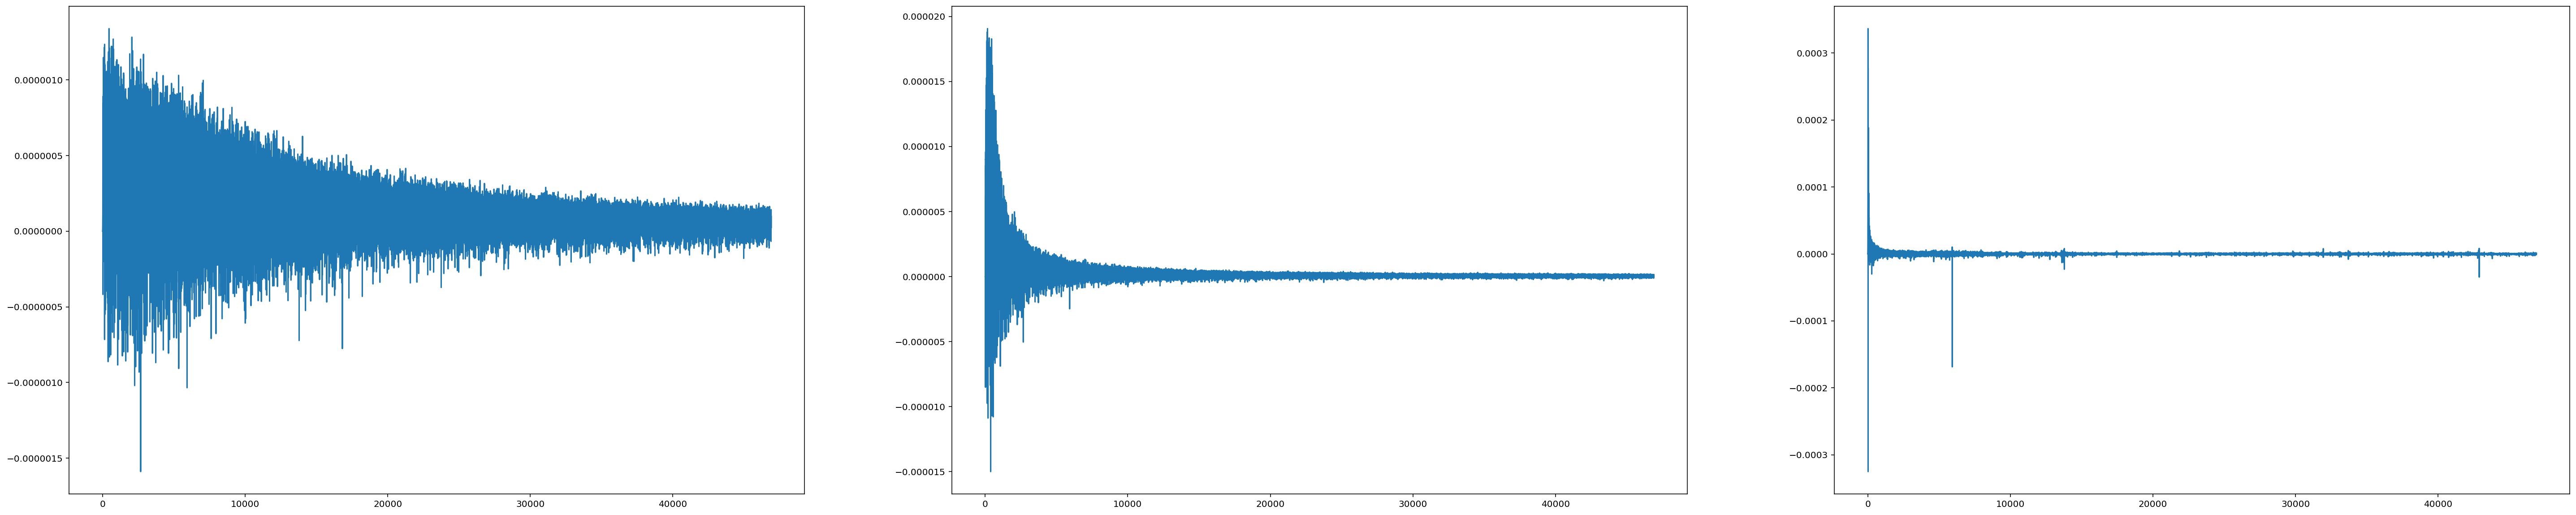

In [196]:
plt.figure(figsize=(50,10))
plt.subplot(1,3,1)
plt.plot(np.array(gradient_history)[:,0])
plt.subplot(1,3,2)
plt.plot(np.array(gradient_history)[:,1])
plt.subplot(1,3,3)
plt.plot(np.array(gradient_history)[:,2])

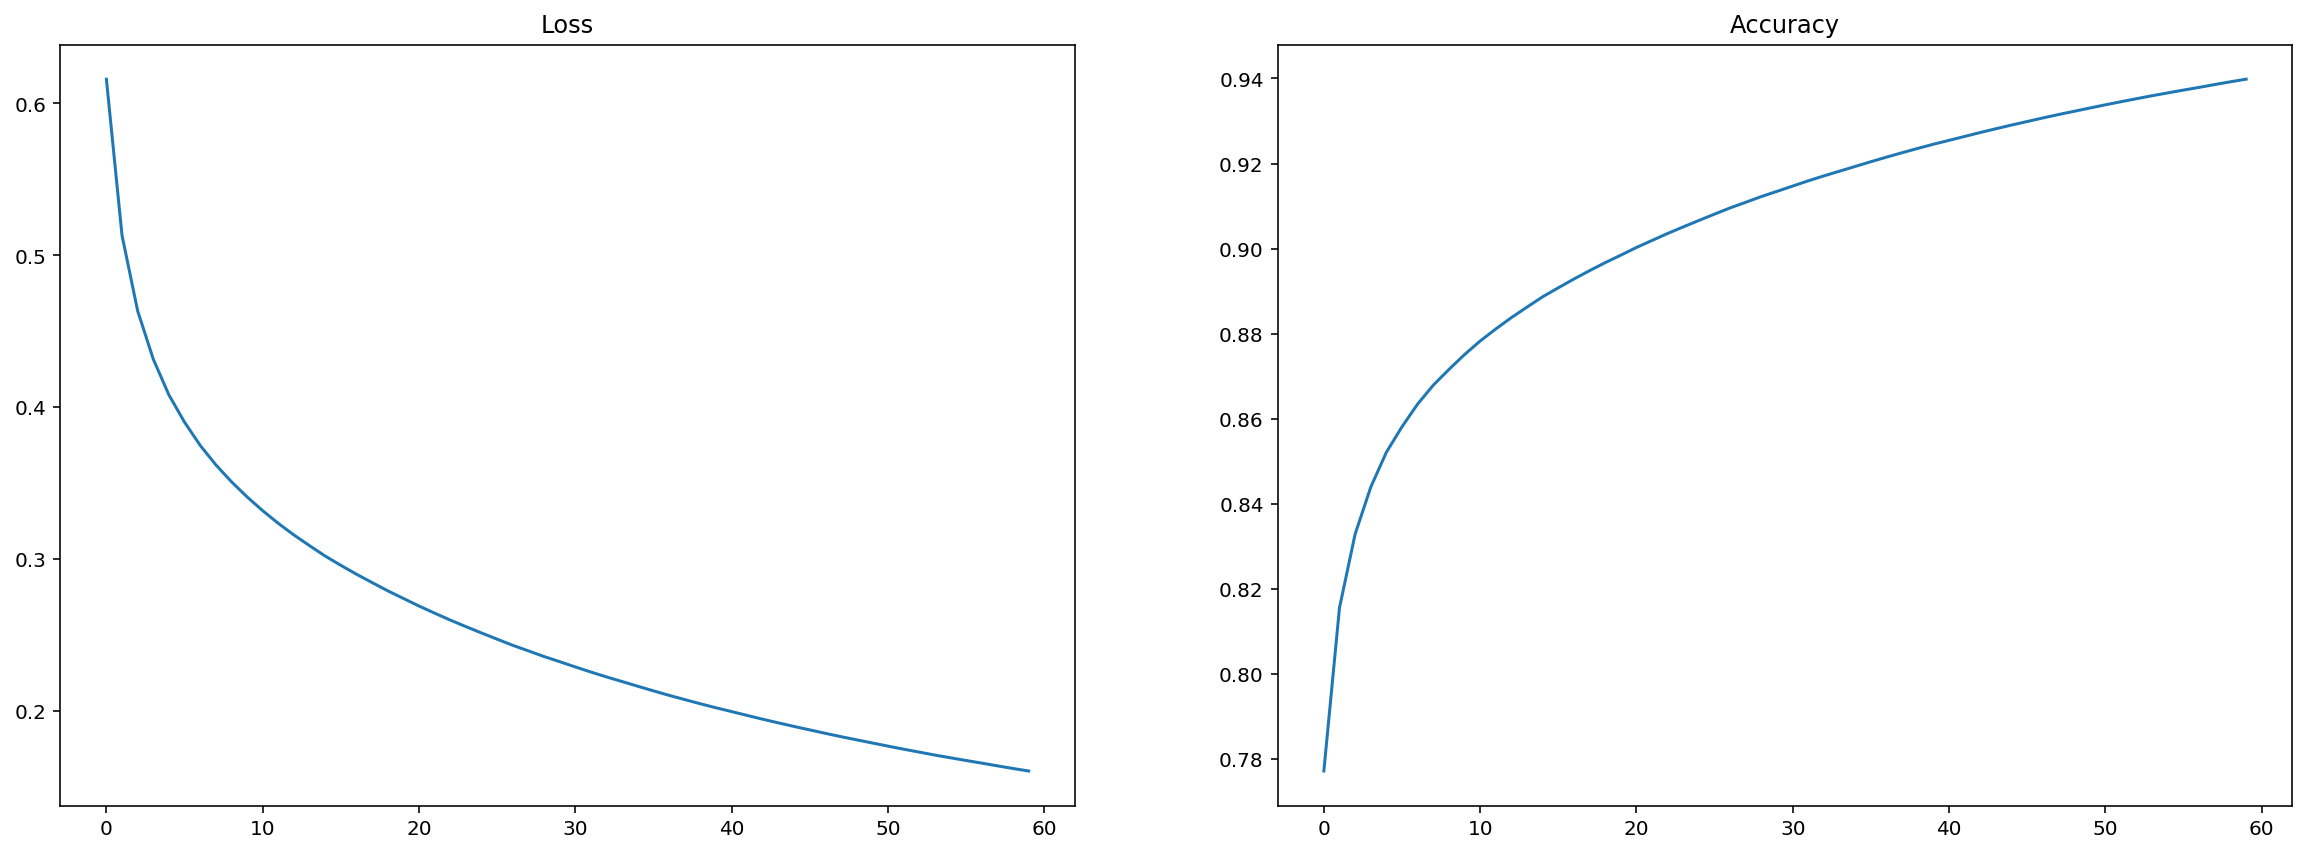

In [172]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(acc_history)

In [174]:
just_eval(fcn, ds_test_fash, supermask=True)

Evaluation Loss: 0.6032153964042664
Evaluation Accuracy: 0.892300009727478


In [175]:
layerwise_output_mean = np.zeros((len(output_history),len(output_history[0])))
#layerwise_output_std = np.zeros((len(layerwise_output_all),len(layerwise_output_all[0])))


for i in range(len(output_history)):
    for j in range(len(output_history[0])):    
        layerwise_output_mean[i][j] = tf.math.reduce_mean(output_history[i][j]).numpy()
        #ayerwise_output_std[i][j] = tf.math.reduce_std(layerwise_output_all[i][j]).numpy()

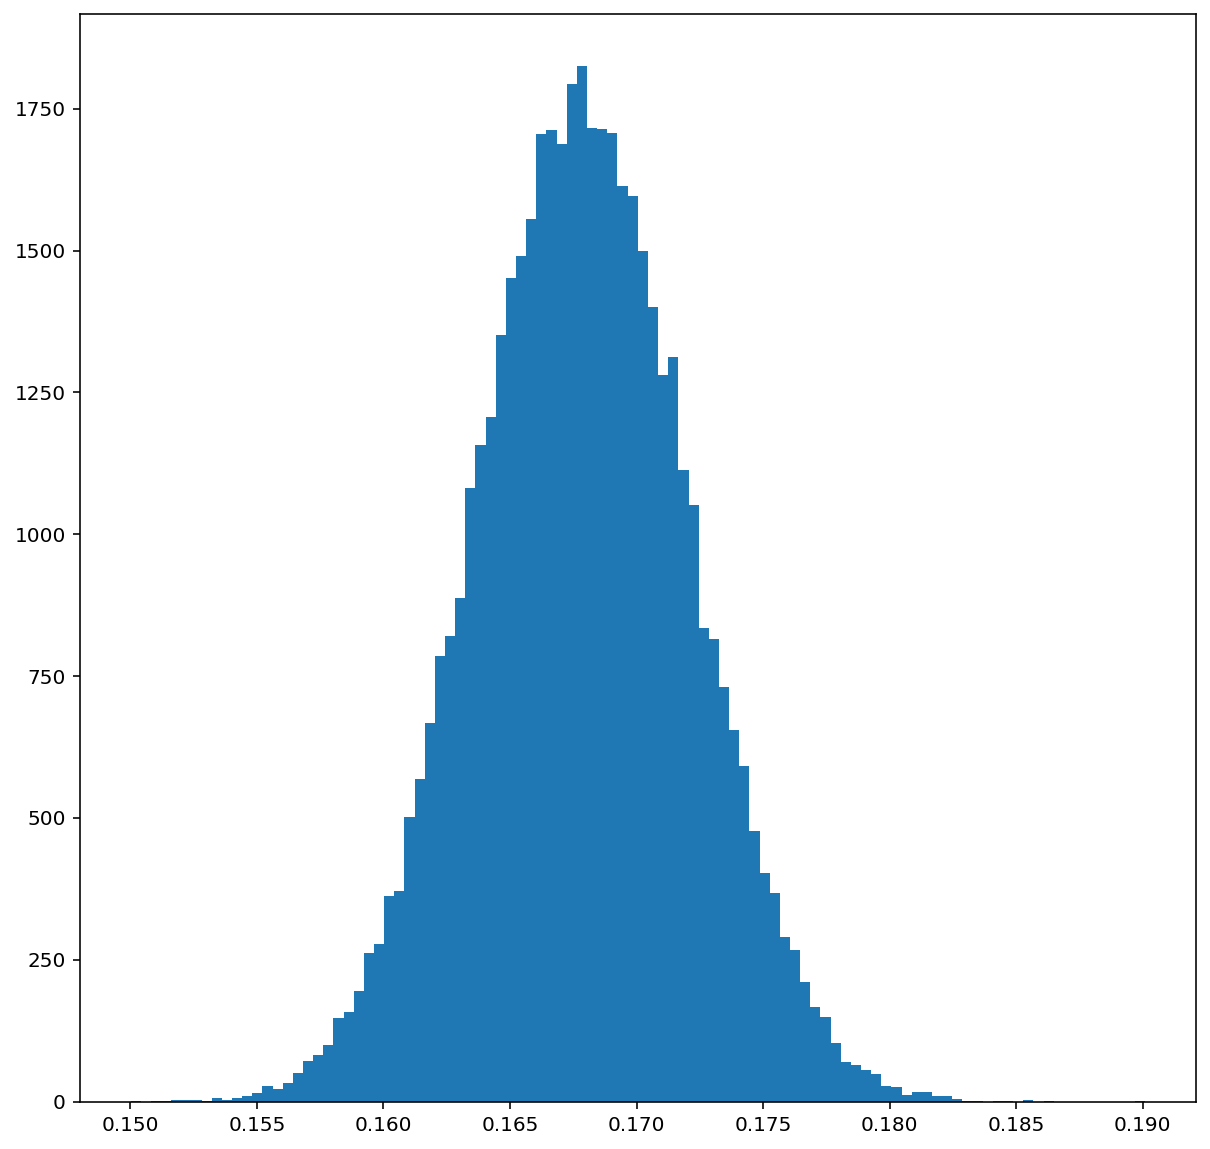

In [176]:
_ = plt.hist(layerwise_output_std[:,0], bins=100)

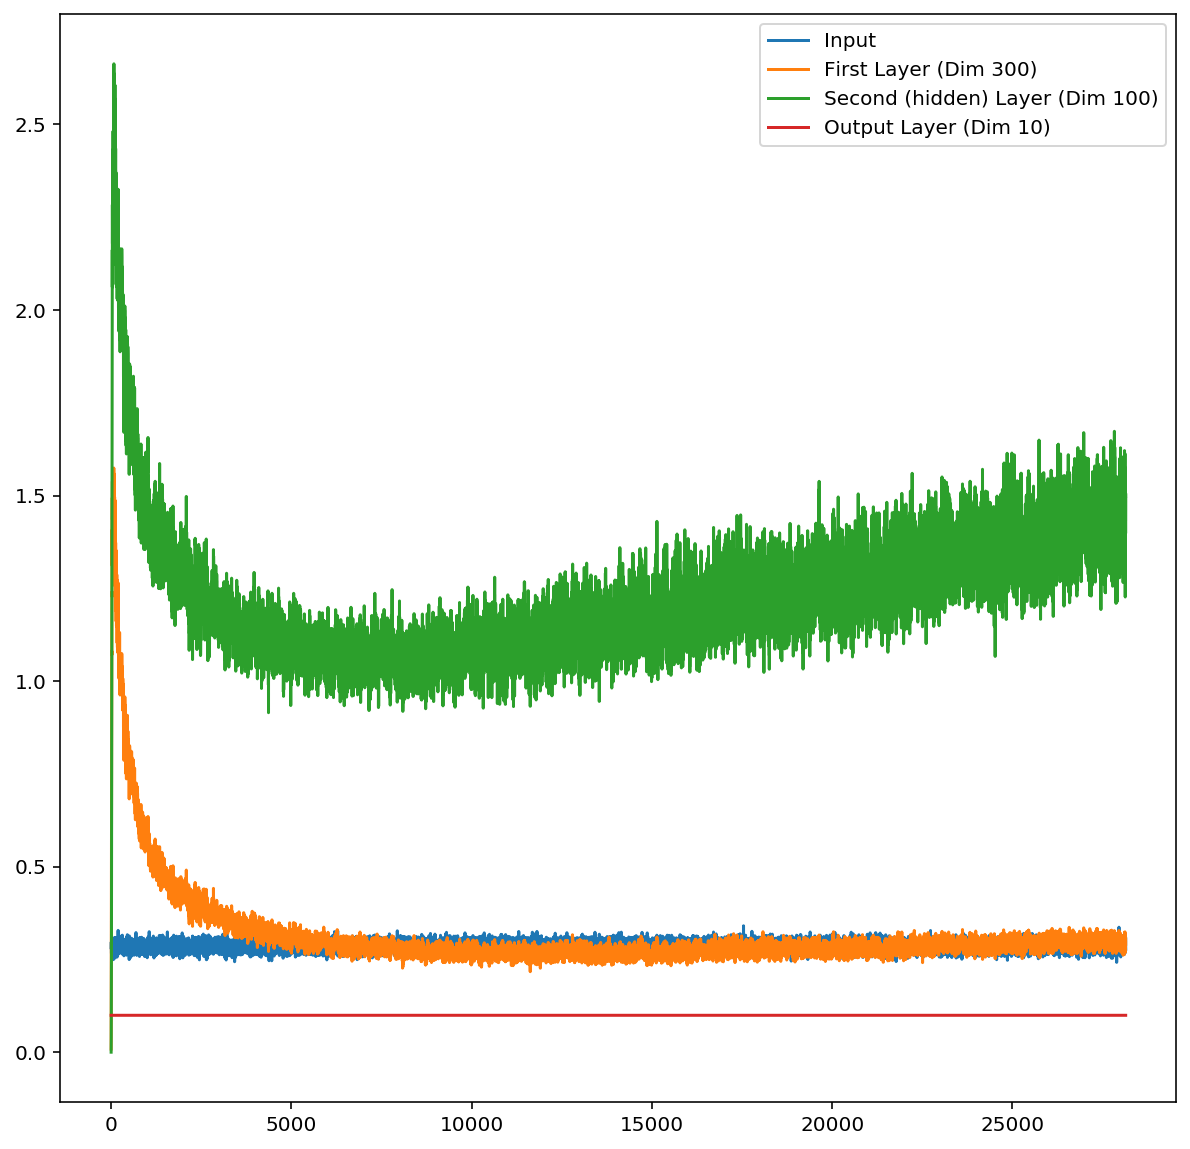

In [177]:
#plt.fill_between(np.arange(len(layerwise_output_mean[:,0])), layerwise_output_mean[:,0]-layerwise_output_std[:,0], layerwise_output_mean[:,0]+layerwise_output_std[:,0], alpha=0.5)
plt.plot(layerwise_output_mean[:,0], label="Input")
plt.plot(layerwise_output_mean[:,1], label="First Layer (Dim 300)")
plt.plot(layerwise_output_mean[:,2], label="Second (hidden) Layer (Dim 100)")
plt.plot(layerwise_output_mean[:,3], label="Output Layer (Dim 10)")
plt.legend()

## Supermask

In [86]:
from custom_nn import Linear, FCN, FCN_Mask

In [87]:
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
fcn_mask = FCN_Mask(input_dim, layer_shapes=LAYER_SHAPES)

In [105]:
for i,layer in enumerate(fcn_mask.layers):
    layer.set_normal_weights(fcn.layers[i].get_weights()[0])

NameError: name 'fcn' is not defined

In [88]:
init = initializer()

initializer


In [168]:
test = 4*np.random.randn(1000000)

In [169]:
test_pos = test[np.where(test > 0)]

(array([1.92929e+05, 1.50773e+05, 9.12880e+04, 4.32630e+04, 1.61750e+04,
        4.59000e+03, 1.01200e+03, 2.03000e+02, 2.00000e+01, 4.00000e+00]),
 array([7.12149869e-06, 2.01465962e+00, 4.02931212e+00, 6.04396463e+00,
        8.05861713e+00, 1.00732696e+01, 1.20879221e+01, 1.41025746e+01,
        1.61172271e+01, 1.81318796e+01, 2.01465321e+01]),
 <a list of 10 Patch objects>)

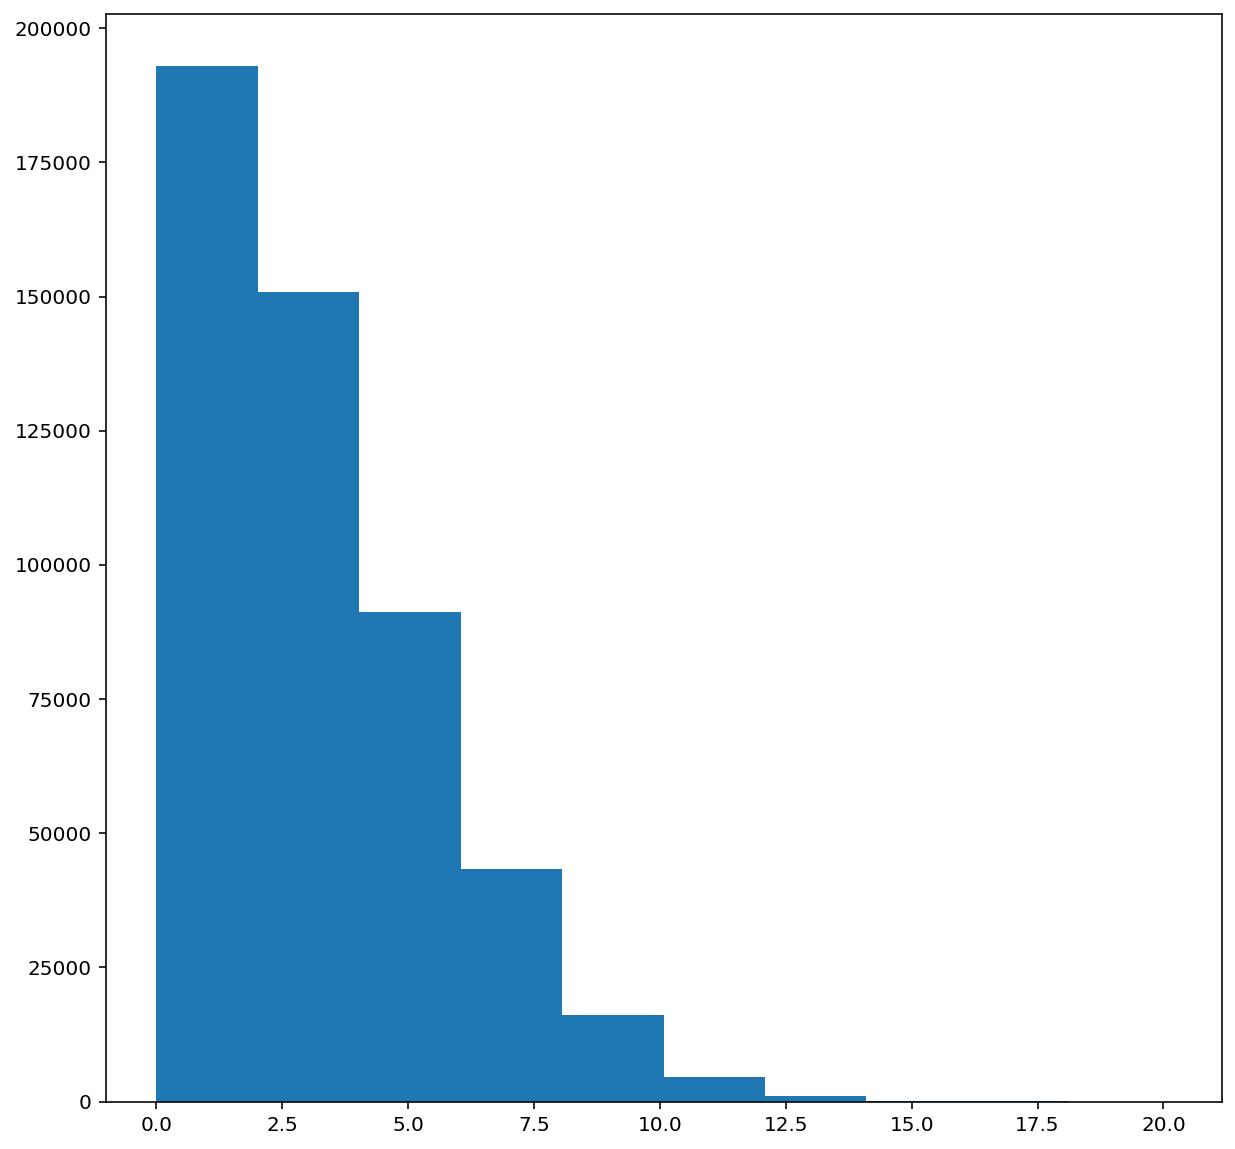

In [170]:
plt.hist(test_pos)

In [171]:
np.mean(test_pos)

3.1885263214469863

In [174]:
np.linalg.norm(fcn_mask.layers[0].bernoulli_mask.numpy(), ord=2)

13.717624

In [73]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-1 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn_mask, initial_weights_mask = init.set_weights_man(fcn_mask, mode="signed_constant", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True)
fcn_mask, initial_masks = init.set_weights_man(fcn_mask, mode="normal", constant=0, mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True)
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)

Glorot normal with sigma 0.0018
Glorot normal with sigma 0.0050
Glorot normal with sigma 0.0182


In [38]:
fcn_mask, initial_weights = init.set_weights_man(fcn_mask, mode="signed_constant", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True)

In [369]:
for i,layer in enumerate(fcn_mask.layers):
    layer.set_normal_weights(fcn.layers[i].get_weights()[0])

In [89]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-3 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn_mask, initial_weights = init.set_weights_man(fcn_mask, mode="uniform", mu=MU, sigma=-3, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=True)
fcn_mask, initial_weights = init.set_weights_man(fcn_mask, mode="uniform", constant=1, mu=MU, sigma=-4, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="", weight_as_constant=False, set_mask=True)
#fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=True)_mas

Glorot uniform with bound 0.0033
Glorot uniform with bound 0.0100
Glorot uniform with bound 0.1000
Glorot uniform with bound 0.0026
Glorot uniform with bound 0.0067
Glorot uniform with bound 0.0200


In [116]:
fcn_mask.layers[0].get_weights()[1].dtype

dtype('float32')

In [113]:
fcn_mask.layers[0].set_weights(fcn_mask.layers[0].get_weights())

In [35]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def custom_loss(y, pred, model):
    x_ent = loss_fn(y,pred)
    no_ones_sqrt = sum([np.sum(layer.bernoulli_mask) for layer in model.layers]) ** 0.5
    
    return x_ent + 0.009 * no_ones_sqrt
                      

In [36]:
def get_zero_rows(model):
    rows_to_be_deleted = []
    rows_to_be_kept = []
    for i,layer in enumerate(model.layers):
        #import pdb; pdb.set_trace()
        a = layer.bernoulli_mask.numpy()
        row_delete = np.where(~a.any(axis=1))[0]
        row_keep = np.where(a.any(axis=1))[0]
        rows_to_be_deleted.append(row_delete)
        rows_to_be_kept.append(row_keep)

        col = np.where(~a.any(axis=0))[0]


        print(f"Layer {i}: {row_delete.shape[0]} Rows can be deleted and {col.shape[0]} Columns")

    return rows_to_be_deleted, rows_to_be_kept

def get_pruned_initial_weights(old_initial_weights, rows_to_be_kept, keep_input=True):
    new_initial_weights = []
    for i in range(len(rows_to_be_kept)):
        #print(i,"/",len(rows_to_be_kept))
        if i is 0:
            # do not delete any input neurons, yet
            if keep_input is True:
                #import pdb; pdb.set_trace()
                w = old_initial_weights[i][:, rows_to_be_kept[1]]
                #w = old_initial_weights[i][0][:, rows_to_be_kept[1]]
            else:
                w = old_initial_weights[i][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
                #w = old_initial_weights[i][0][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #b = old_initial_weights[i][1][:rows_to_be_kept[i+1].shape[0]]
        elif i is len(rows_to_be_kept)-1:
            w = old_initial_weights[i][rows_to_be_kept[i],:]
            #w = old_initial_weights[i][0][rows_to_be_kept[i],:]
            #b = old_initial_weights[i][1]
        else:
            w = old_initial_weights[i][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #w = old_initial_weights[i][0][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            #b = old_initial_weights[i][1][:rows_to_be_kept[i+1].shape[0]]


        #wb = [w,b]
        new_initial_weights.append(w)
        #new_initial_weights.append(wb)
        
    #import pdb; pdb.set_trace()

    return new_initial_weights

def get_new_shape(input_dim, rows_to_be_kept, keep_input=True):
    new_shape = []
    for i in range(len(rows_to_be_kept)):
        if i == 0:
            if keep_input is True:
                tmp = [input_dim, rows_to_be_kept[1].shape[0]]
            else:
                tmp = [rows_to_be_kept[i].shape[0], rows_to_be_kept[i+1].shape[0]]
        elif i == len(rows_to_be_kept)-1:
            tmp = [rows_to_be_kept[i].shape[0], 10]
        else:
            tmp = [rows_to_be_kept[i].shape[0], rows_to_be_kept[i+1].shape[0]]
        new_shape.append(tmp)
    return new_shape

In [37]:
from copy import copy

# Try to exclude rows/cols that are all zero from trainable weights

In [ ]:
var_list1 = [variables from first 5 layers]
var_list2 = [the rest of variables]
opt1 = tf.train.GradientDescentOptimizer(0.00001)
opt2 = tf.train.GradientDescentOptimizer(0.0001)
grads = tf.gradients(loss, var_list1 + var_list2)
grads1 = grads[:len(var_list1)]
grads2 = grads[len(var_list1):]
tran_op1 = opt1.apply_gradients(zip(grads1, var_list1))
train_op2 = opt2.apply_gradients(zip(grads2, var_list2))
train_op = tf.group(train_op1, train_op2)

In [ ]:
a = [tf.math.reduce_sum(x, axis=1) for x in trainable_weights]
b = [tf.where(x == 0) for x in a]
c = [tf.where(x != 0) for x in a]

nonzero_rows_trainable = [trainable_weights[i][c[i]] for i in range(len(c))]
zero_rows_nontrainable = [trainable_weights[i][b[i]] for i in range(len(b))]

# pseudo code
gradients(trainable_weights[c])


In [ ]:
intermediate_tensor = tf.math.reduce_sum(x, 1)
zero_vector = tf.zeros(shape=(1,1), dtype=tf.float32)

In [367]:
bool_mask = tf.not_equal(fcn_mask.layers[0].bernoulli_mask, 0.)

In [368]:
tf.boolean_mask(fcn_mask.layers[0].bernoulli_mask, bool_mask)

<tf.Tensor: shape=(10850,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [302]:
def train_supermask_model_prune(model, ds_train, epochs=6, prune_neurons=False, keep_input=True):
    
    lr = 200
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)#tf.keras.optimizers.SGD(learning_rate=190, momentum=0.9) , momentum=0.9, nesterov=True
    
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    remaining_ones_ratio_history = []
    
    #input_dim = model.layers[0].shape[0]
    
    #new_initial_weights = [layer.get_normal_weights().numpy() for layer in model.layers]
    
    #new_initial_masks = [layer.mask.numpy() for layer in model.layers]
    
    #all_trainable_vars_original = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model.trainable_variables]).numpy()
    
    #smaller_model = copy(model)
    
    layerwise_output_all = []
    gradient_history = []
    
    epoch_half = epochs // 2
    
    for epoch in range(epochs):
        
        #if epoch == epoch_half:
        #    optimizer = tf.keras.optimizers.SGD(learning_rate = lr*0.7, momentum=0.9)
        
        #for i,layer in enumerate(model.layers):
        #    print(f"Layer {i} multiplier: {layer.multiplier:.4f}")
        
        #if epoch == 140:
            #optimizer = tf.keras.optimizers.SGD(learning_rate=70, momentum=0.9)
    
        #print(f"Start of epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted, layerwise_output = model(x_batch_train)
                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)
                #loss = custom_loss(y_batch_train, predicted, model)
            #var_list1 = model.trainable_weights[:1]
            #var_list2 = model.trainable_weights[1:]
            
            trainable_weights_row_sum = [tf.math.reduce_sum(layer, axis=1) for layer in model.trainable_weights]
            
            
            
            grads = tape.gradient(loss, model.trainable_weights)

            gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            #print(f"Gradient value mean: {tf.math.reduce_mean(grads[0]).numpy()}")
            
            optimizer.apply_gradients(zip(grads1, model.trainable_weights))
            
            #optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)

            acc_metric(y_batch_train,predicted)
        
        #save the last gradient of each epoch
        #gradient_history.append(grads)
            
        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())
        
        
        global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in fcn_mask.layers])
        global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in fcn_mask.layers])
        
        remaining_ones_ratio = (global_no_ones/global_size)*100
        print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
        remaining_ones_ratio_history.append(remaining_ones_ratio)

    return model, loss_history, acc_history, layerwise_output_all, gradient_history, remaining_ones_ratio_history

In [90]:
def train_supermask_model(model, ds_train, epochs=6, prune_neurons=False, keep_input=True):
    
    lr = 200
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1, momentum=0.9)#tf.keras.optimizers.SGD(learning_rate=190, momentum=0.9) , momentum=0.9, nesterov=True
    optimizer_2 = tf.keras.optimizers.SGD(learning_rate=2, momentum=0.9)
    optimizer_3 = tf.keras.optimizers.SGD(learning_rate=2, momentum=0.9)
    
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    loss_history = []
    acc_history = []
    
    remaining_ones_ratio_history = []
    
    #input_dim = model.layers[0].shape[0]
    
    #new_initial_weights = [layer.get_normal_weights().numpy() for layer in model.layers]
    
    #new_initial_masks = [layer.mask.numpy() for layer in model.layers]
    
    #all_trainable_vars_original = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model.trainable_variables]).numpy()
    
    #smaller_model = copy(model)
    
    layerwise_output_all = []
    gradient_history = []
    
    epoch_half = epochs // 2
    
    for epoch in range(epochs):
        
        #if epoch == epoch_half:
        #    optimizer = tf.keras.optimizers.SGD(learning_rate = lr*0.7, momentum=0.9)
        
        #for i,layer in enumerate(model.layers):
        #    print(f"Layer {i} multiplier: {layer.multiplier:.4f}")
        
        #if epoch == 140:
            #optimizer = tf.keras.optimizers.SGD(learning_rate=70, momentum=0.9)
    
        #print(f"Start of epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted, layerwise_output = model(x_batch_train, epoch)
                layerwise_output_all.append(layerwise_output)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)
                #loss = custom_loss(y_batch_train, predicted, model)
            #var_list1 = model.trainable_weights[:1]
            #var_list2 = model.trainable_weights[1:]
            
            grads = tape.gradient(loss, model.trainable_weights)
            
            #print(f"Gradients: {grads}")
            
            grads1 = grads[:1]
            grads2 = grads[1:2]
            grads3 = grads[2:]
            
            gradient_history.append([tf.reduce_mean(g).numpy() for g in grads])
            #print(f"Gradient value mean: {tf.math.reduce_mean(grads[0]).numpy()}")
            
            optimizer.apply_gradients(zip(grads1, model.trainable_weights[:1]))
            optimizer_2.apply_gradients(zip(grads2, model.trainable_weights[1:2]))
            optimizer_3.apply_gradients(zip(grads3, model.trainable_weights[2:]))
            #optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)

            acc_metric(y_batch_train,predicted)
        
        #save the last gradient of each epoch
        #gradient_history.append(grads)
            
        print(f"End of Epoch: {epoch+1}: Accuracy = {acc_metric.result().numpy():.6f} --- Mean Loss = {loss_metric.result().numpy():.6f}")
        
        loss_history.append(loss_metric.result().numpy())
        acc_history.append(acc_metric.result().numpy())
        
        
        global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in fcn_mask.layers])
        global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in fcn_mask.layers])
        
        remaining_ones_ratio = (global_no_ones/global_size)*100
        print(f"{remaining_ones_ratio:.2f}% of weights are 'remaining'")
        remaining_ones_ratio_history.append(remaining_ones_ratio)

    return model, loss_history, acc_history, layerwise_output_all, gradient_history, remaining_ones_ratio_history

In [65]:
from custom_nn import Linear, FCN, FCN_Mask

In [106]:
fcn_mask, loss_history_mask, acc_history_mask, layerwise_output_all, gradient_history, ones_ratio_history = train_supermask_model(fcn_mask, ds_train_fash, epochs=100)

End of Epoch: 1: Accuracy = 0.439250 --- Mean Loss = 1.516674
12.70% of weights are 'remaining'
End of Epoch: 2: Accuracy = 0.451083 --- Mean Loss = 1.454360
12.87% of weights are 'remaining'
End of Epoch: 3: Accuracy = 0.471411 --- Mean Loss = 1.396377
13.06% of weights are 'remaining'
End of Epoch: 4: Accuracy = 0.507933 --- Mean Loss = 1.317997
13.28% of weights are 'remaining'
End of Epoch: 5: Accuracy = 0.539310 --- Mean Loss = 1.254111
13.41% of weights are 'remaining'
End of Epoch: 6: Accuracy = 0.568844 --- Mean Loss = 1.191310
13.47% of weights are 'remaining'
End of Epoch: 7: Accuracy = 0.590590 --- Mean Loss = 1.143419
13.51% of weights are 'remaining'
End of Epoch: 8: Accuracy = 0.607117 --- Mean Loss = 1.106291
13.58% of weights are 'remaining'
End of Epoch: 9: Accuracy = 0.620126 --- Mean Loss = 1.076978
13.64% of weights are 'remaining'
End of Epoch: 10: Accuracy = 0.630732 --- Mean Loss = 1.052286
13.72% of weights are 'remaining'
End of Epoch: 11: Accuracy = 0.639479 -

KeyboardInterrupt: 

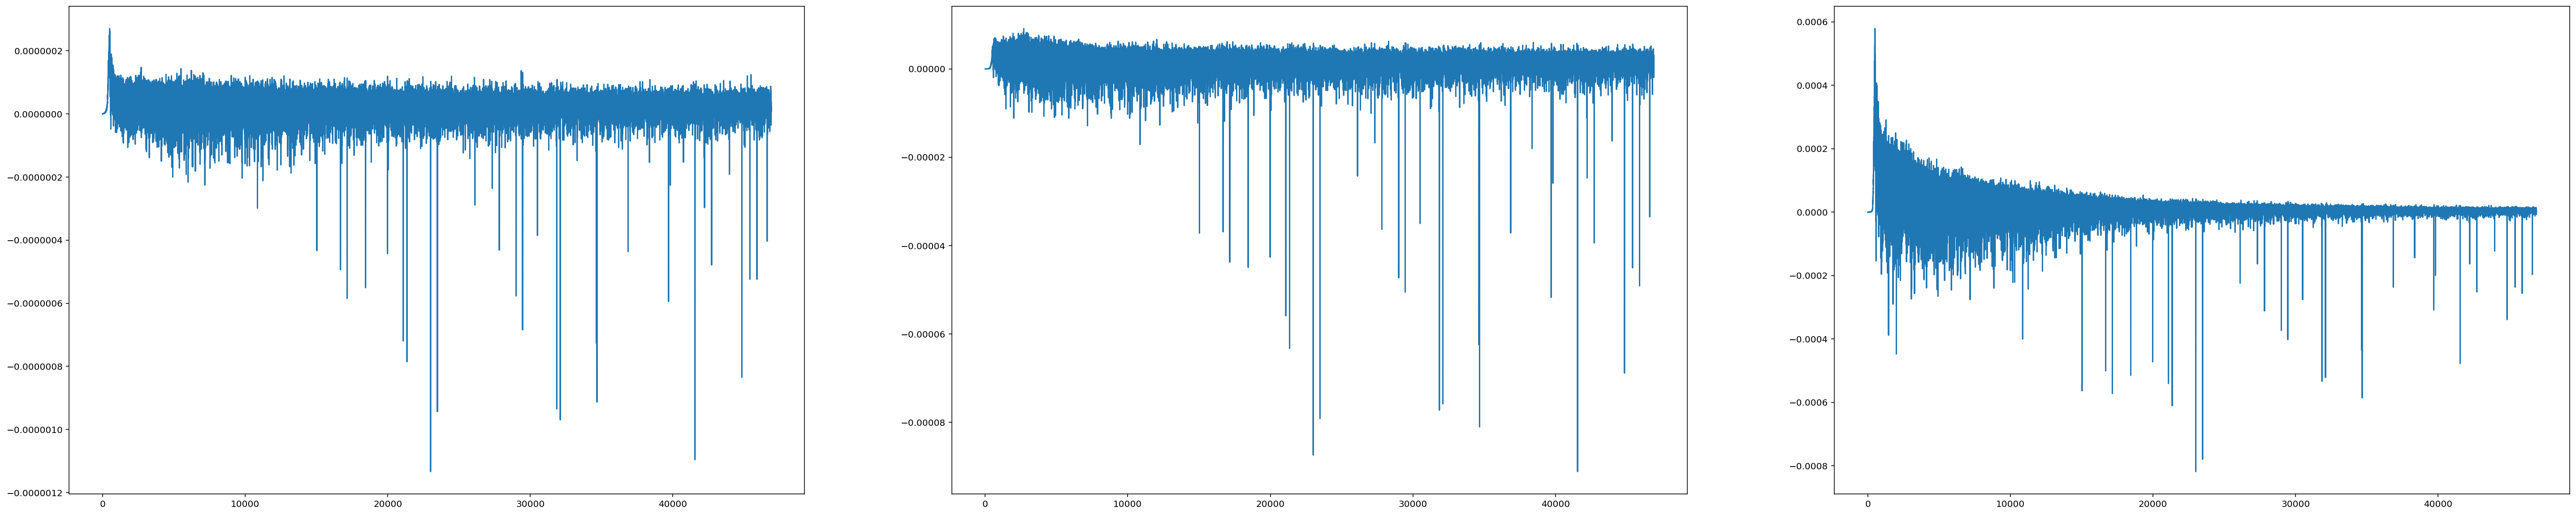

In [92]:
plt.figure(figsize=(50,10))
plt.subplot(1,3,1)
plt.plot(np.array(gradient_history)[:,0])
plt.subplot(1,3,2)
plt.plot(np.array(gradient_history)[:,1])
plt.subplot(1,3,3)
plt.plot(np.array(gradient_history)[:,2])

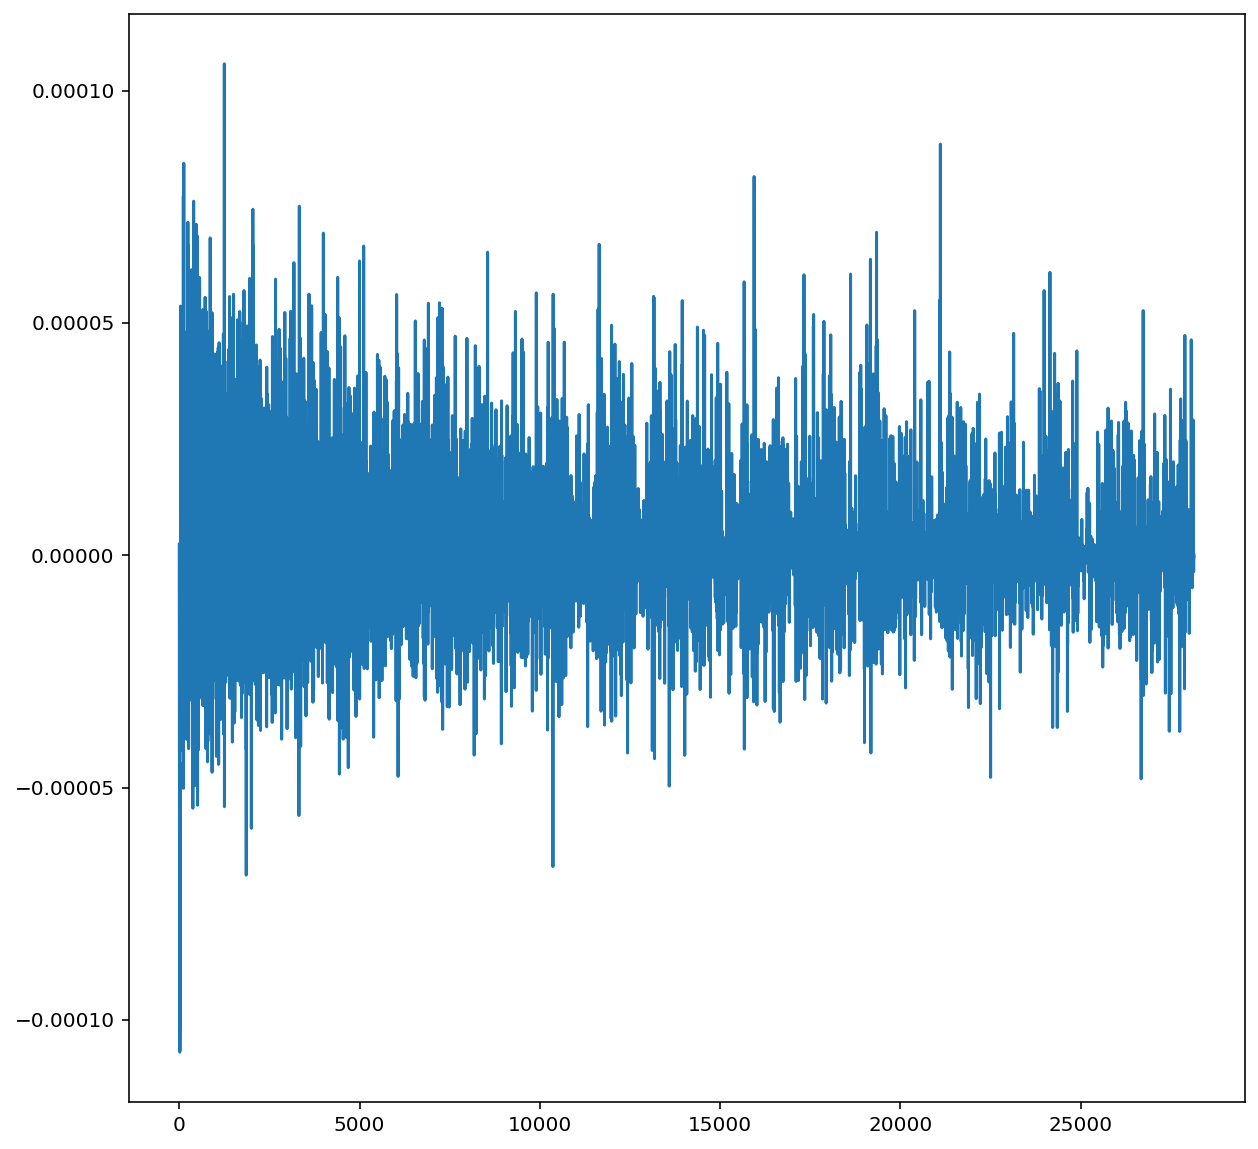

In [165]:
plt.plot(np.array(gradient_history)[:,0])

In [155]:
gradient_history[:][0]

[-3.9830053e-10, -3.4207825e-09, -5.3811558e-08]

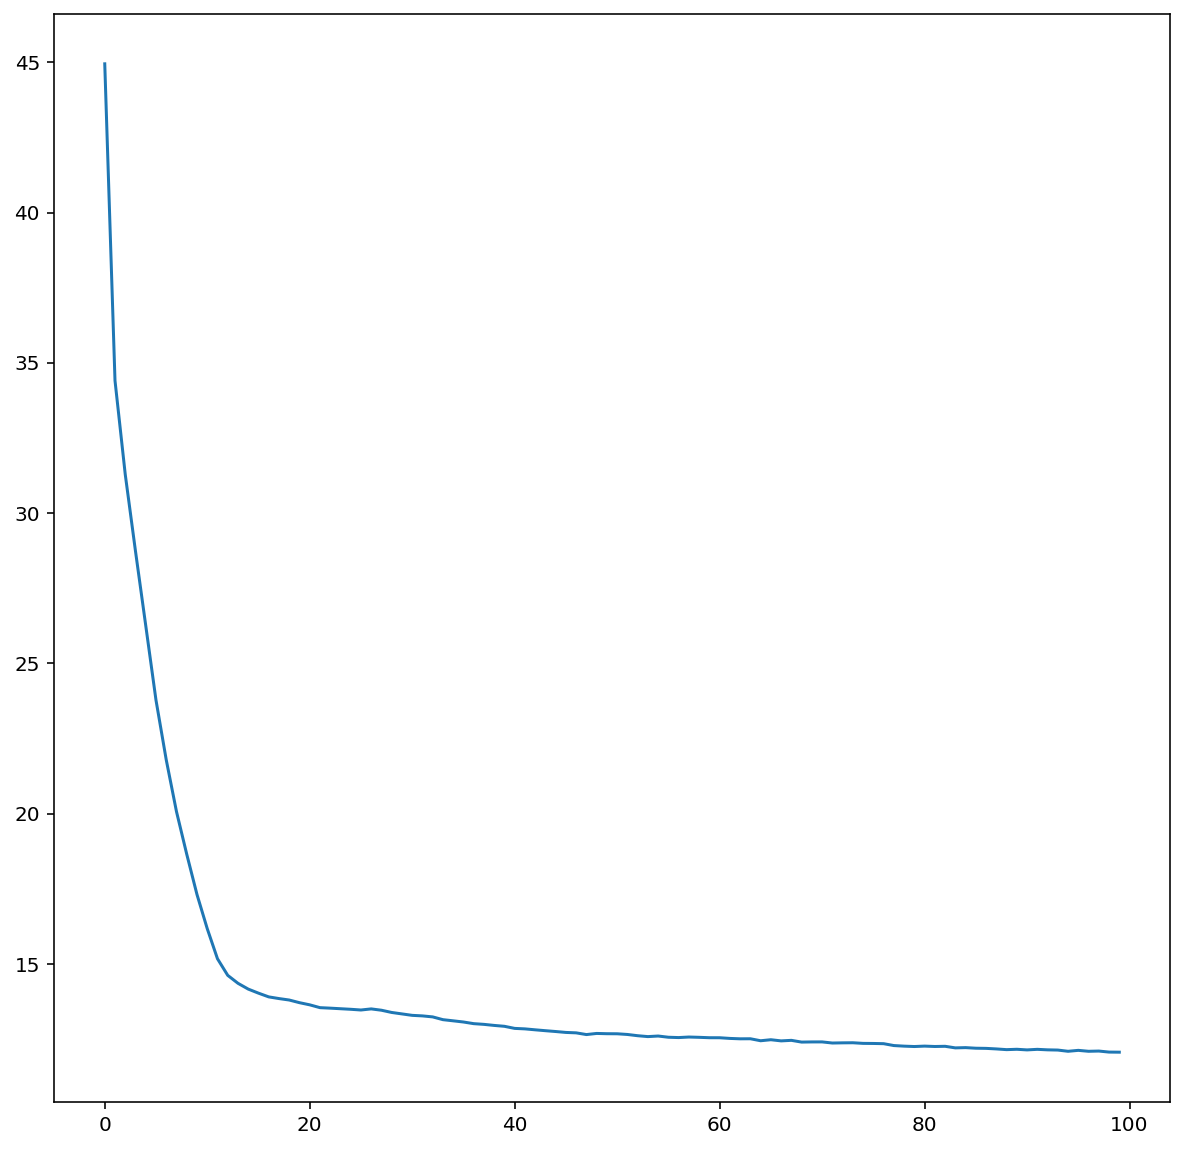

In [93]:
plt.plot(ones_ratio_history)

In [95]:
layerwise_output_mean = np.zeros((len(layerwise_output_all),len(layerwise_output_all[0])))
layerwise_output_std = np.zeros((len(layerwise_output_all),len(layerwise_output_all[0])))


for i in range(len(layerwise_output_all)):
    for j in range(len(layerwise_output_all[0])):    
        layerwise_output_mean[i][j] = tf.math.reduce_mean(layerwise_output_all[i][j]).numpy()
        layerwise_output_std[i][j] = tf.math.reduce_std(layerwise_output_all[i][j]).numpy()

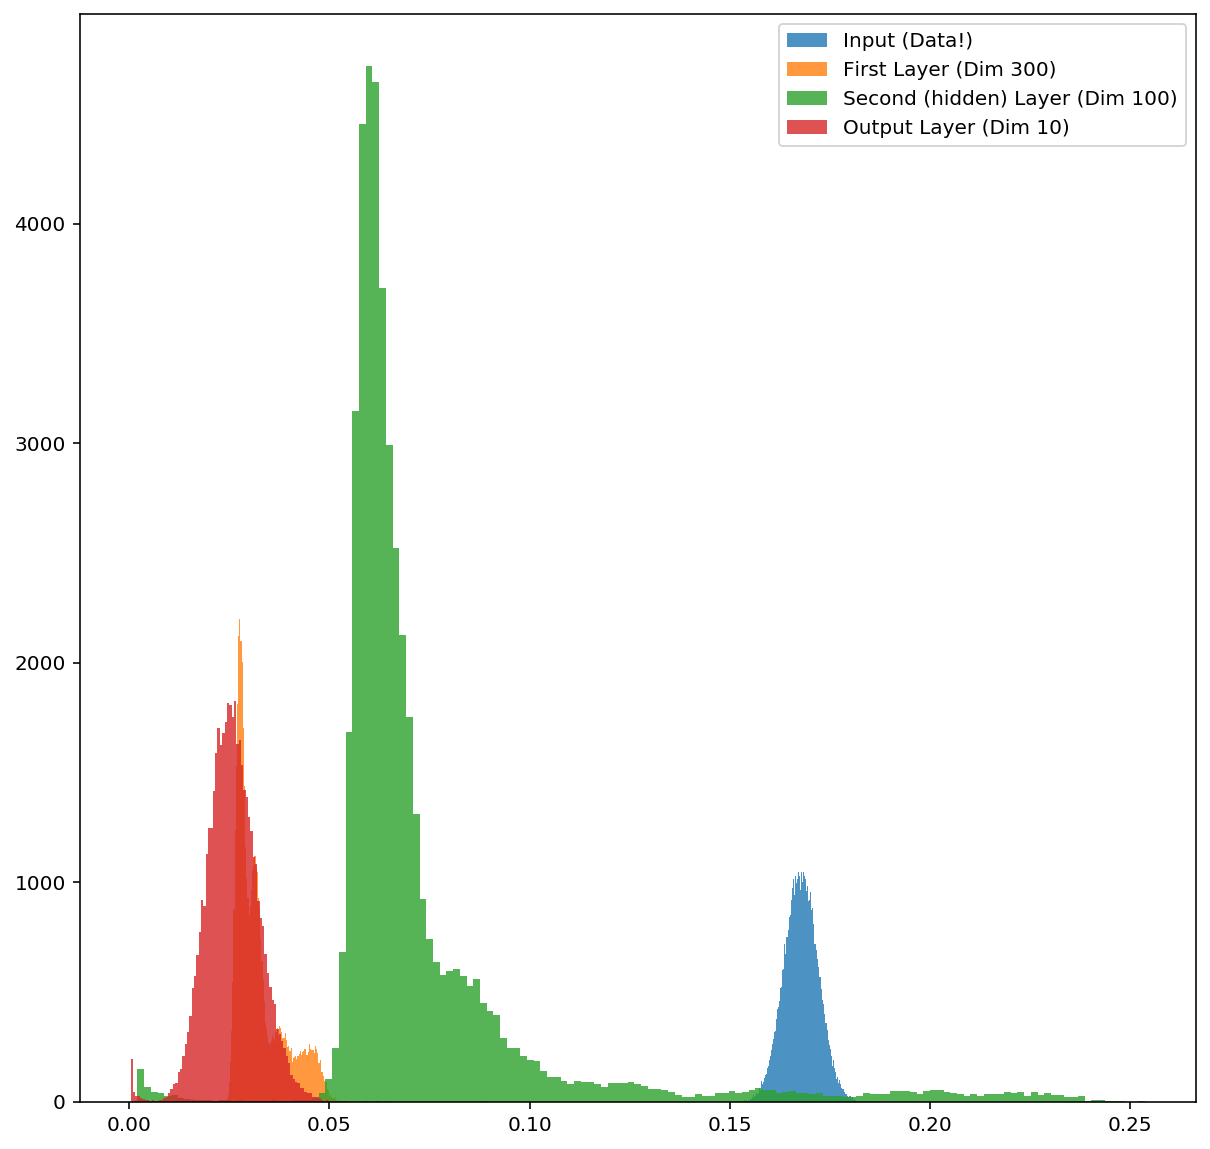

In [96]:
_ = plt.hist(layerwise_output_std[:,0], bins=150, alpha=0.8, label="Input (Data!)")
_ = plt.hist(layerwise_output_std[:,1], bins=150, alpha=0.8,  label="First Layer (Dim 300)")
_ = plt.hist(layerwise_output_std[:,2], bins=150, alpha=0.8,  label="Second (hidden) Layer (Dim 100)")
_ = plt.hist(layerwise_output_std[:,3], bins=150, alpha=0.8,  label="Output Layer (Dim 10)")
plt.legend()

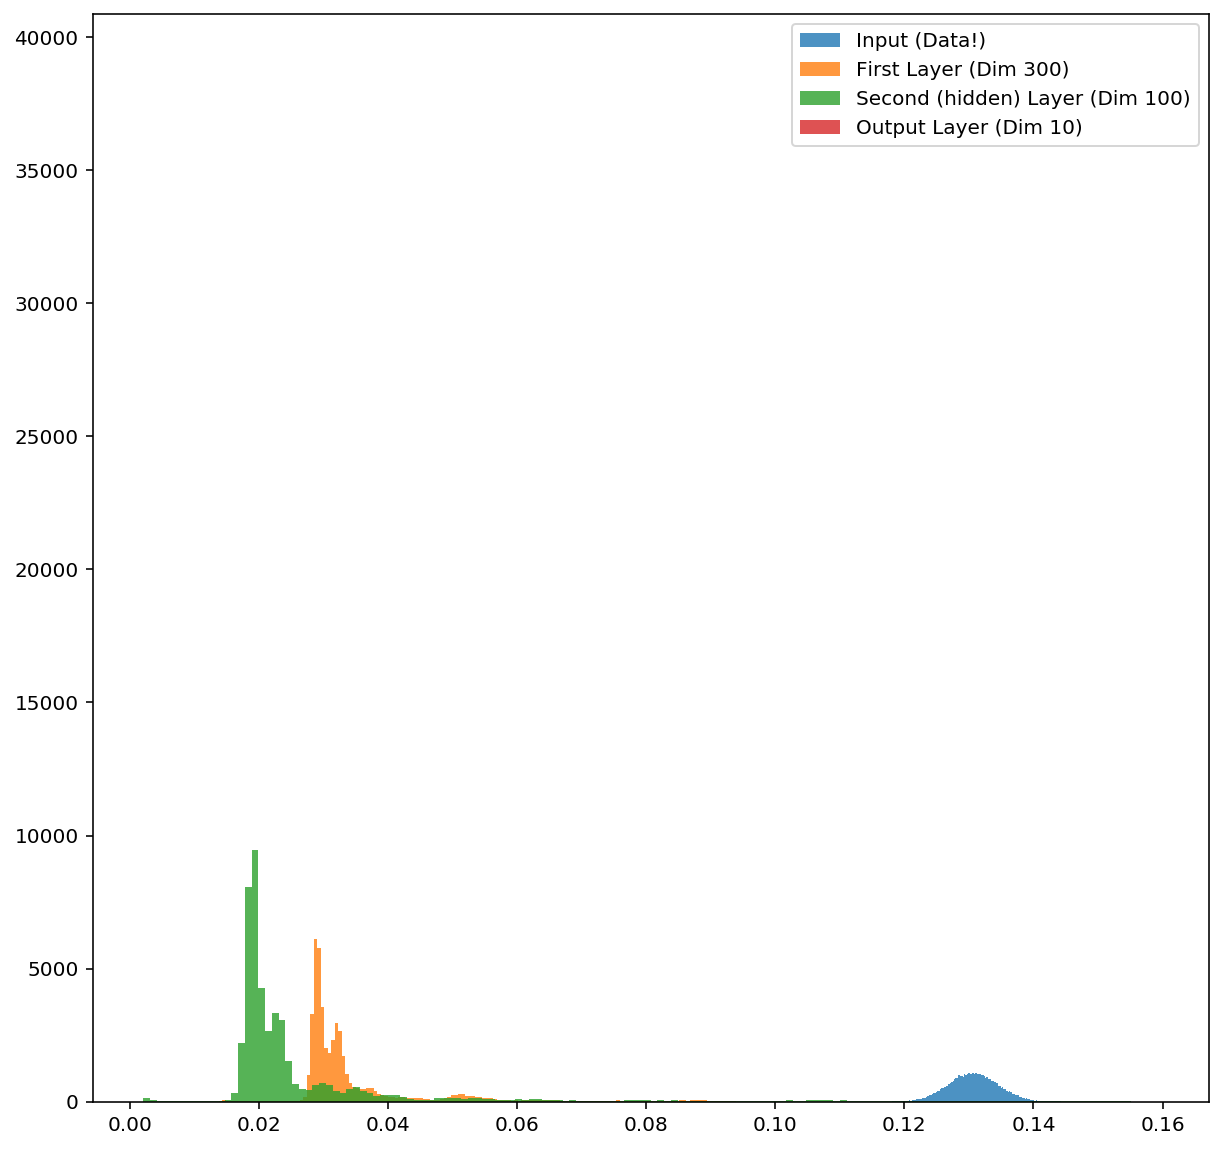

In [97]:
_ = plt.hist(layerwise_output_mean[:,0], bins=150, alpha=0.8, label="Input (Data!)")
_ = plt.hist(layerwise_output_mean[:,1], bins=150, alpha=0.8,  label="First Layer (Dim 300)")
_ = plt.hist(layerwise_output_mean[:,2], bins=150, alpha=0.8,  label="Second (hidden) Layer (Dim 100)")
_ = plt.hist(layerwise_output_mean[:,3], bins=150, alpha=0.8,  label="Output Layer (Dim 10)")
plt.legend()

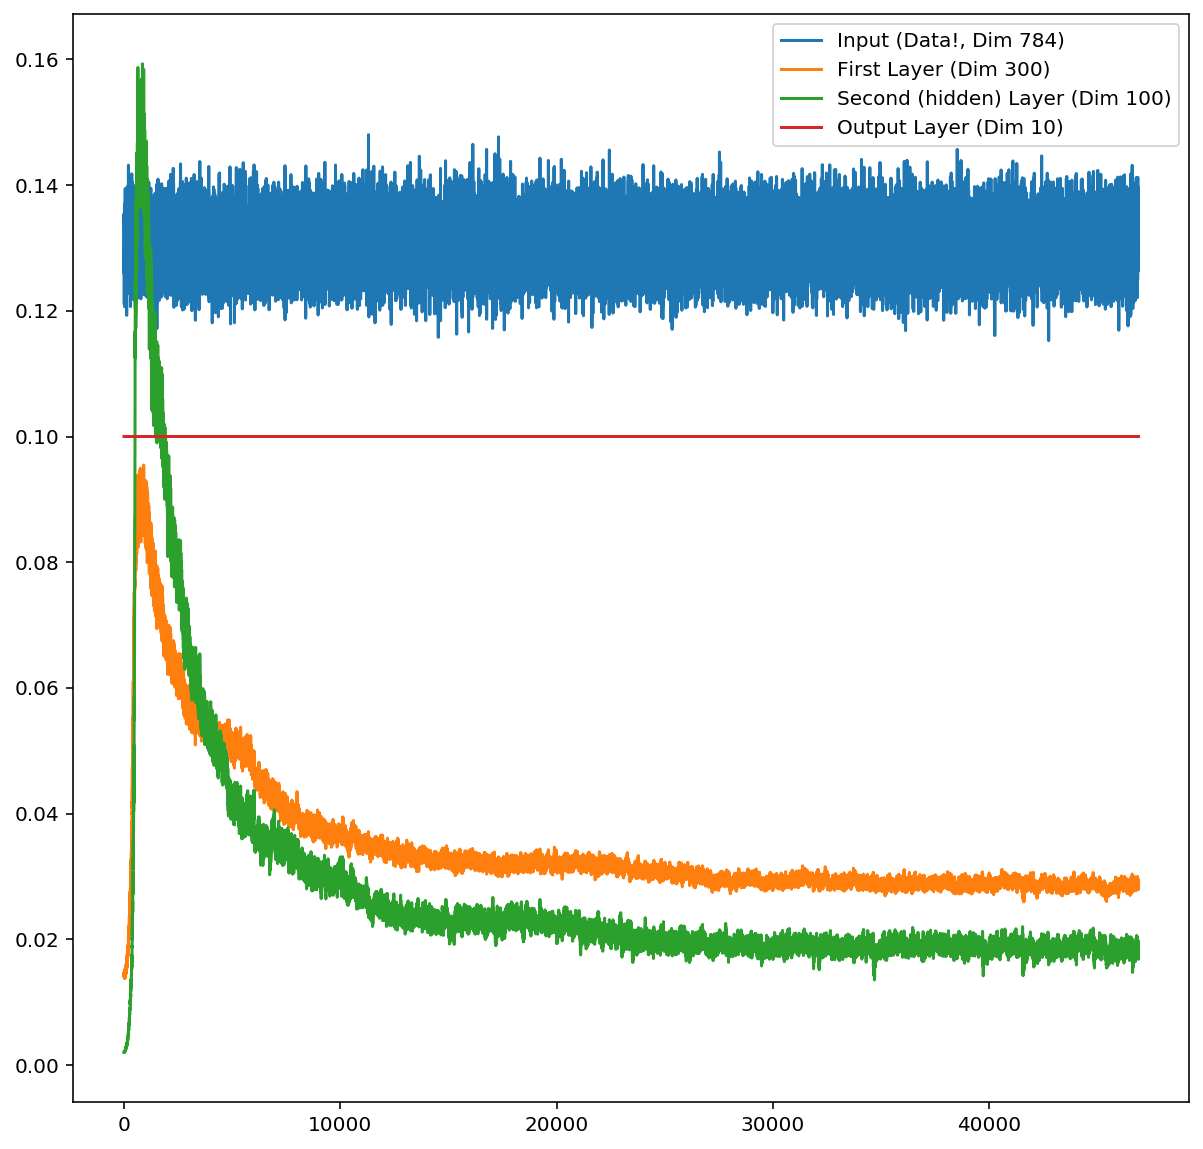

In [98]:
#plt.fill_between(np.arange(len(layerwise_output_mean[:,0])), layerwise_output_mean[:,0]-layerwise_output_std[:,0], layerwise_output_mean[:,0]+layerwise_output_std[:,0], alpha=0.5)
plt.plot(layerwise_output_mean[:,0], label="Input (Data!, Dim 784)")
plt.plot(layerwise_output_mean[:,1], label="First Layer (Dim 300)")
plt.plot(layerwise_output_mean[:,2], label="Second (hidden) Layer (Dim 100)")
plt.plot(layerwise_output_mean[:,3], label="Output Layer (Dim 10)")
plt.legend()

In [99]:
import gc
gc.collect()

22

In [116]:
masks_trained_weights = [layer.bernoulli_mask for layer in fcn_mask.layers]

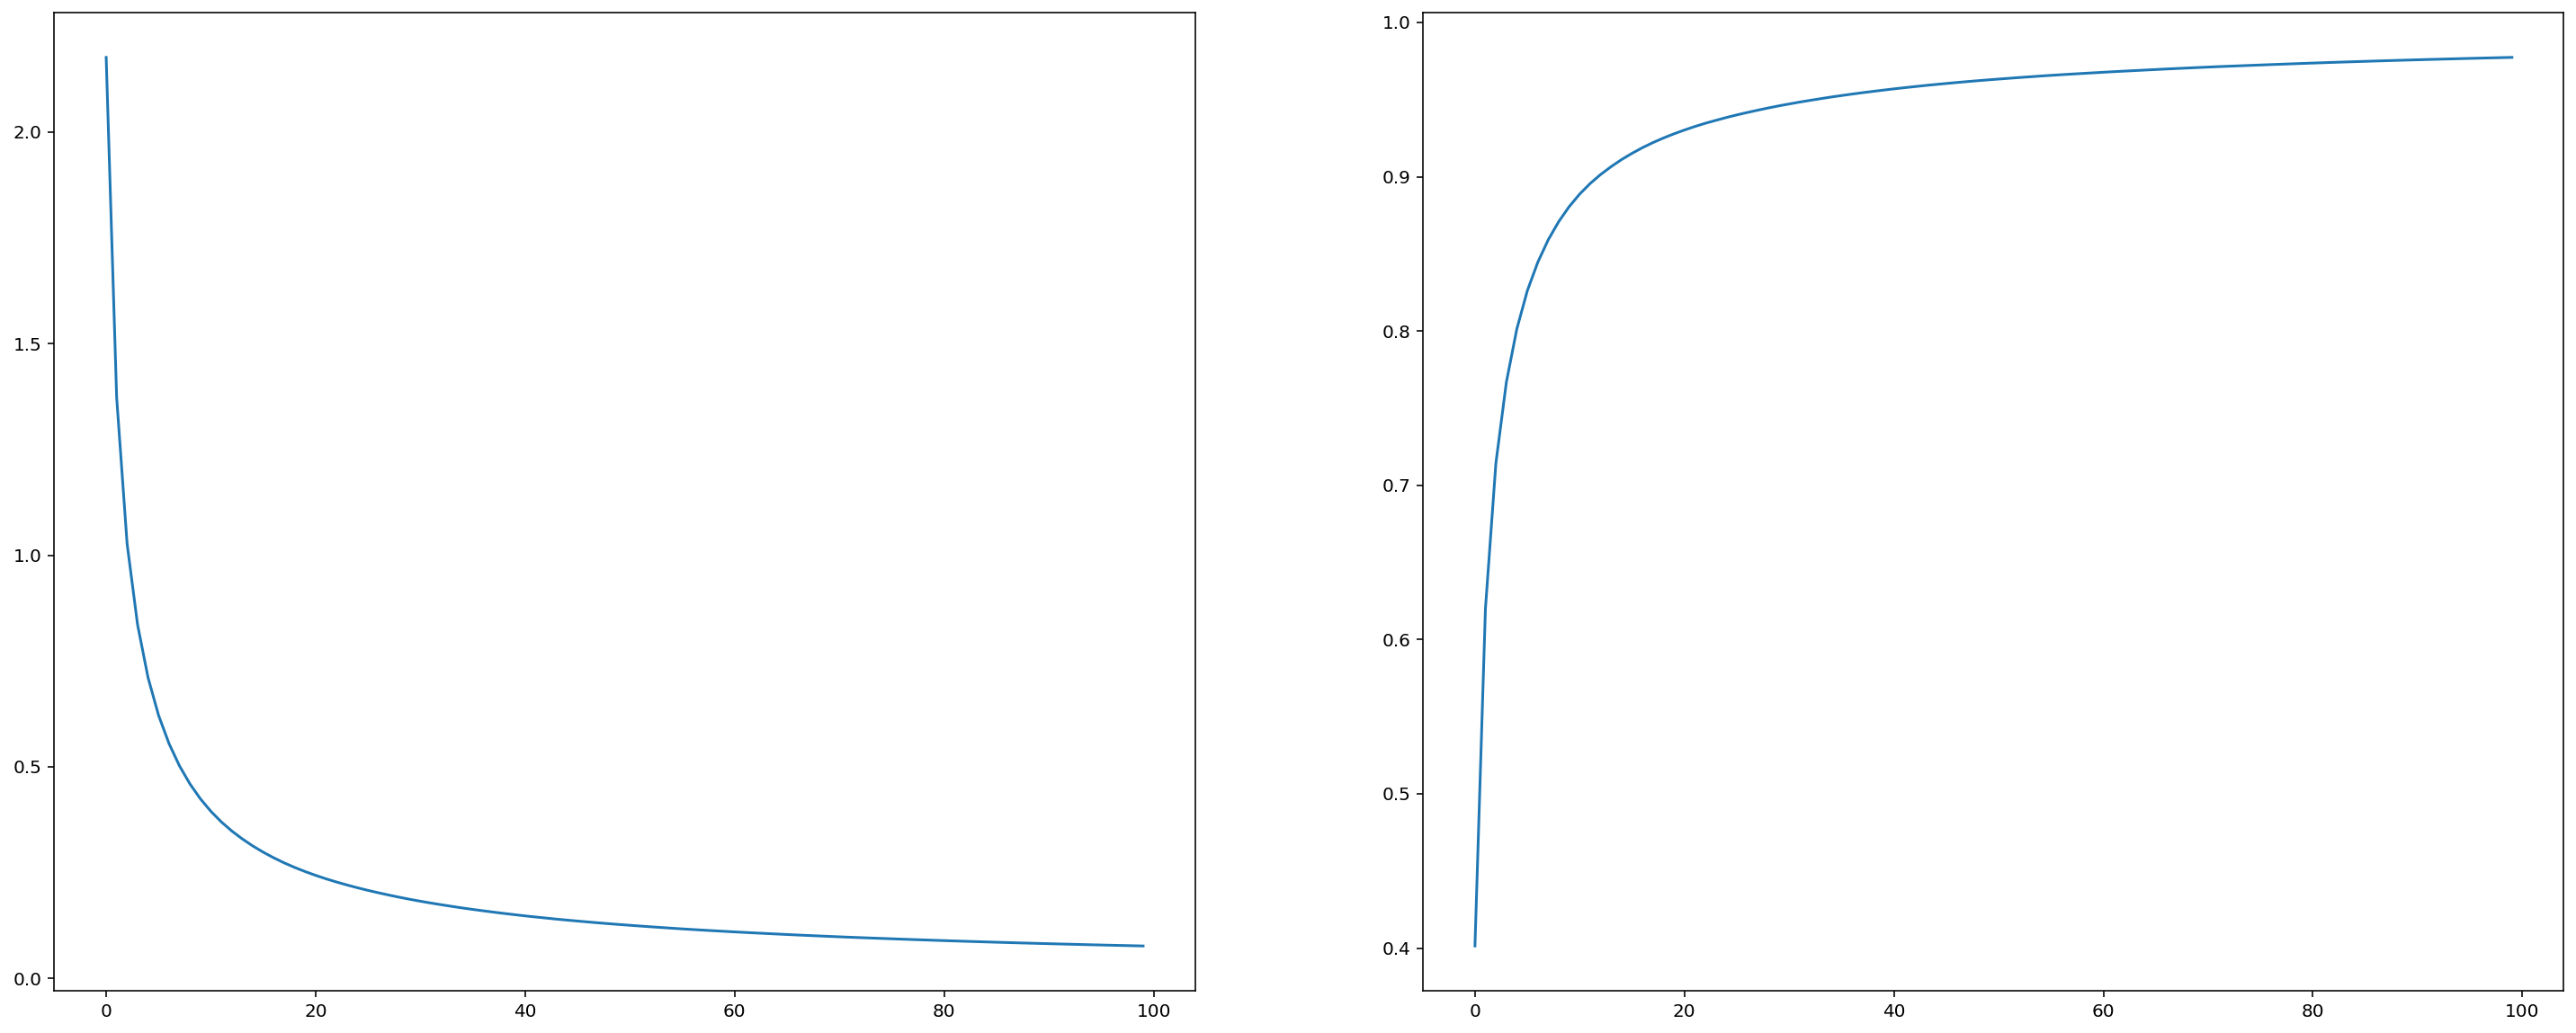

In [100]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(loss_history_mask)
plt.subplot(1,2,2)
plt.plot(acc_history_mask)

In [101]:
global_no_ones = np.sum([np.sum(layer.bernoulli_mask) for layer in fcn_mask.layers])
global_size = np.sum([tf.size(layer.bernoulli_mask) for layer in fcn_mask.layers])

In [102]:
global_no_ones / global_size

0.1206649135987979

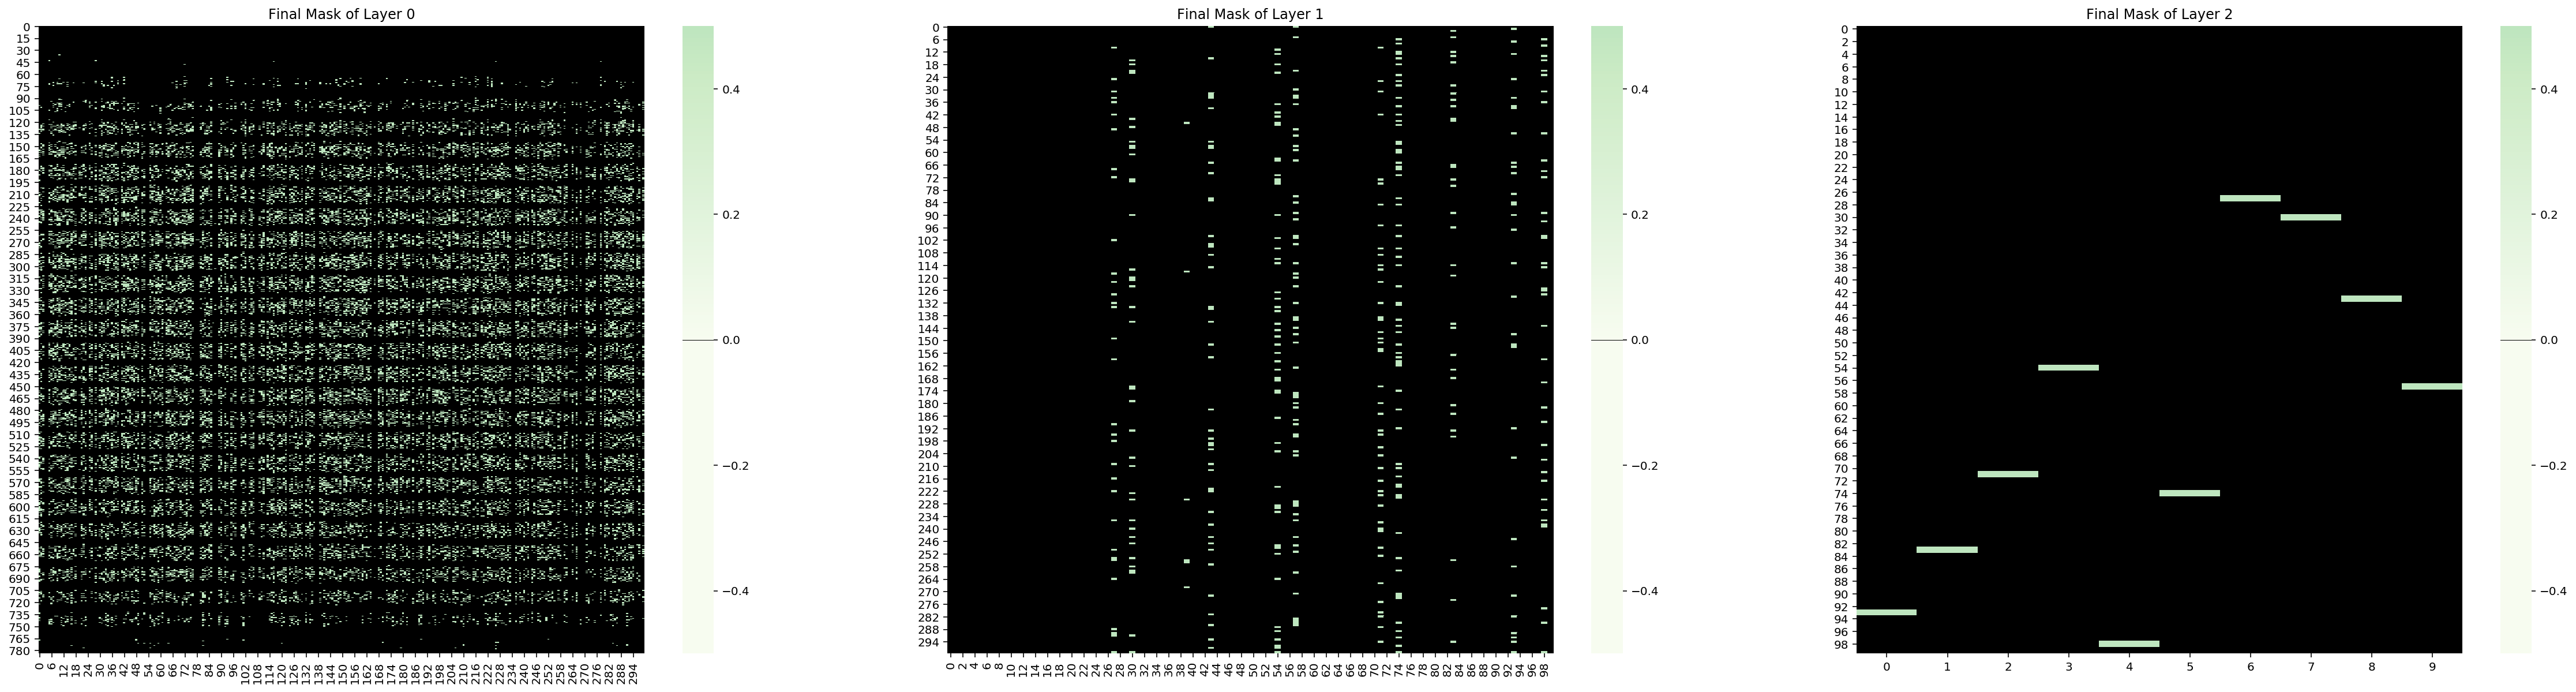

In [103]:
plt.figure(figsize=(40,10))
for layer in range(len(fcn_mask.trainable_weights)):
    plt.subplot(1,len(fcn_mask.trainable_weights),layer+1)
    mask = fcn_mask.layers[layer].bernoulli_mask.numpy()
    _ = sns.heatmap(mask, cbar=True, cmap=cmap, vmin=-0.5, vmax=0.5)
    plt.title(f"Final Mask of Layer {layer}")
#plt.savefig("./img/final_mask_delta_high_same_sign.png", dpi=1000, bbox_inches="tight")

In [104]:
for layer in fcn_mask.layers:
    print(layer.multiplier)

tf.Tensor(11.136715, shape=(), dtype=float32)
tf.Tensor(104.166664, shape=(), dtype=float32)
tf.Tensor(150.0, shape=(), dtype=float32)


In [105]:
just_eval(fcn_mask, ds_test_mnist, supermask=True)

Evaluation Loss: 0.09957744181156158
Evaluation Accuracy: 0.9713000059127808


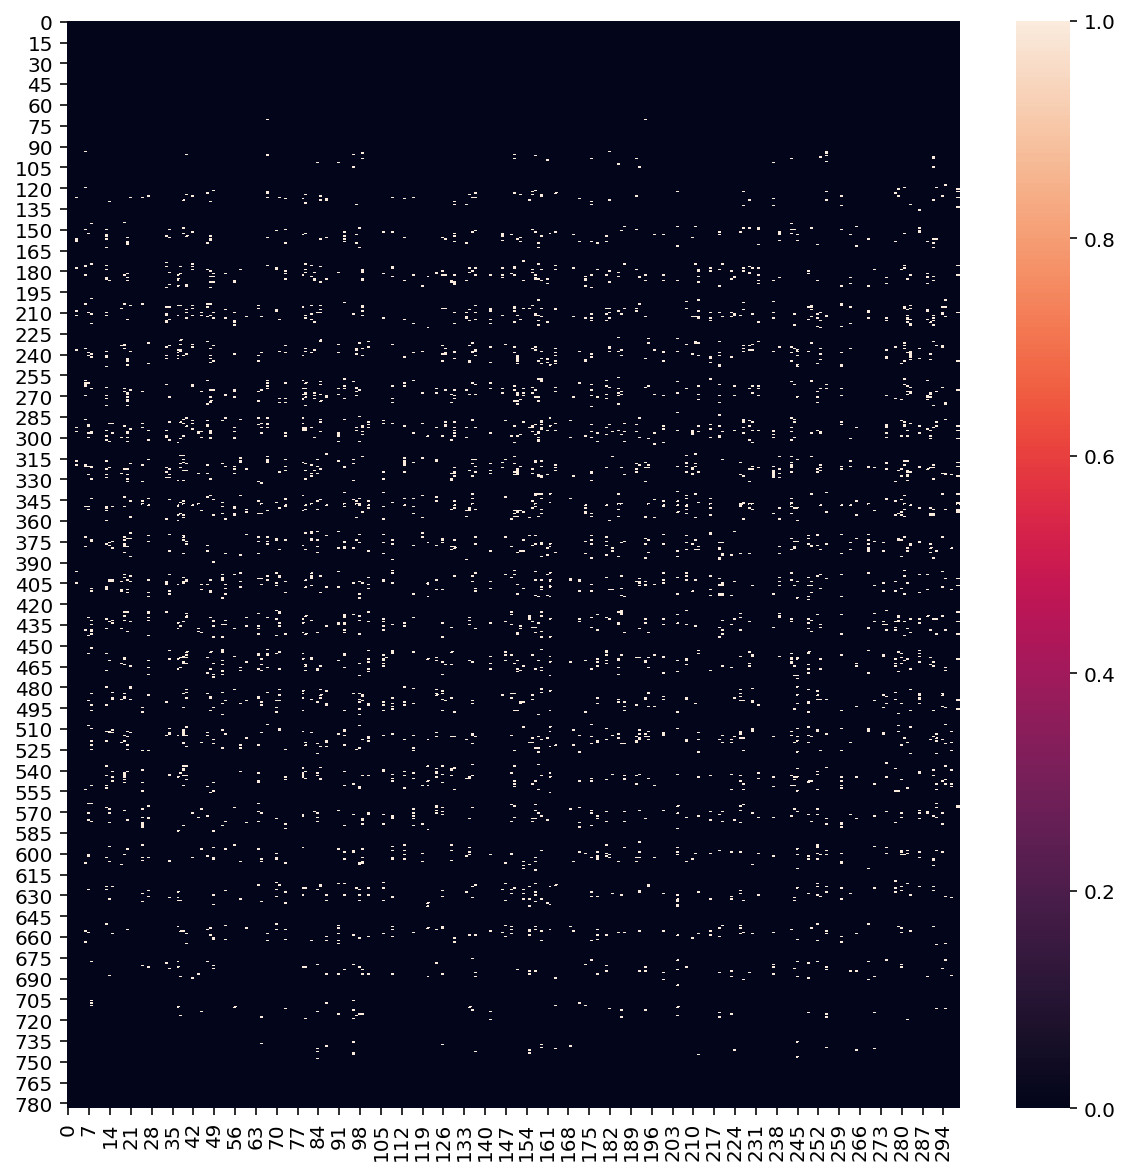

In [406]:
sns.heatmap(fcn_mask.layers[0].bernoulli_mask.numpy())

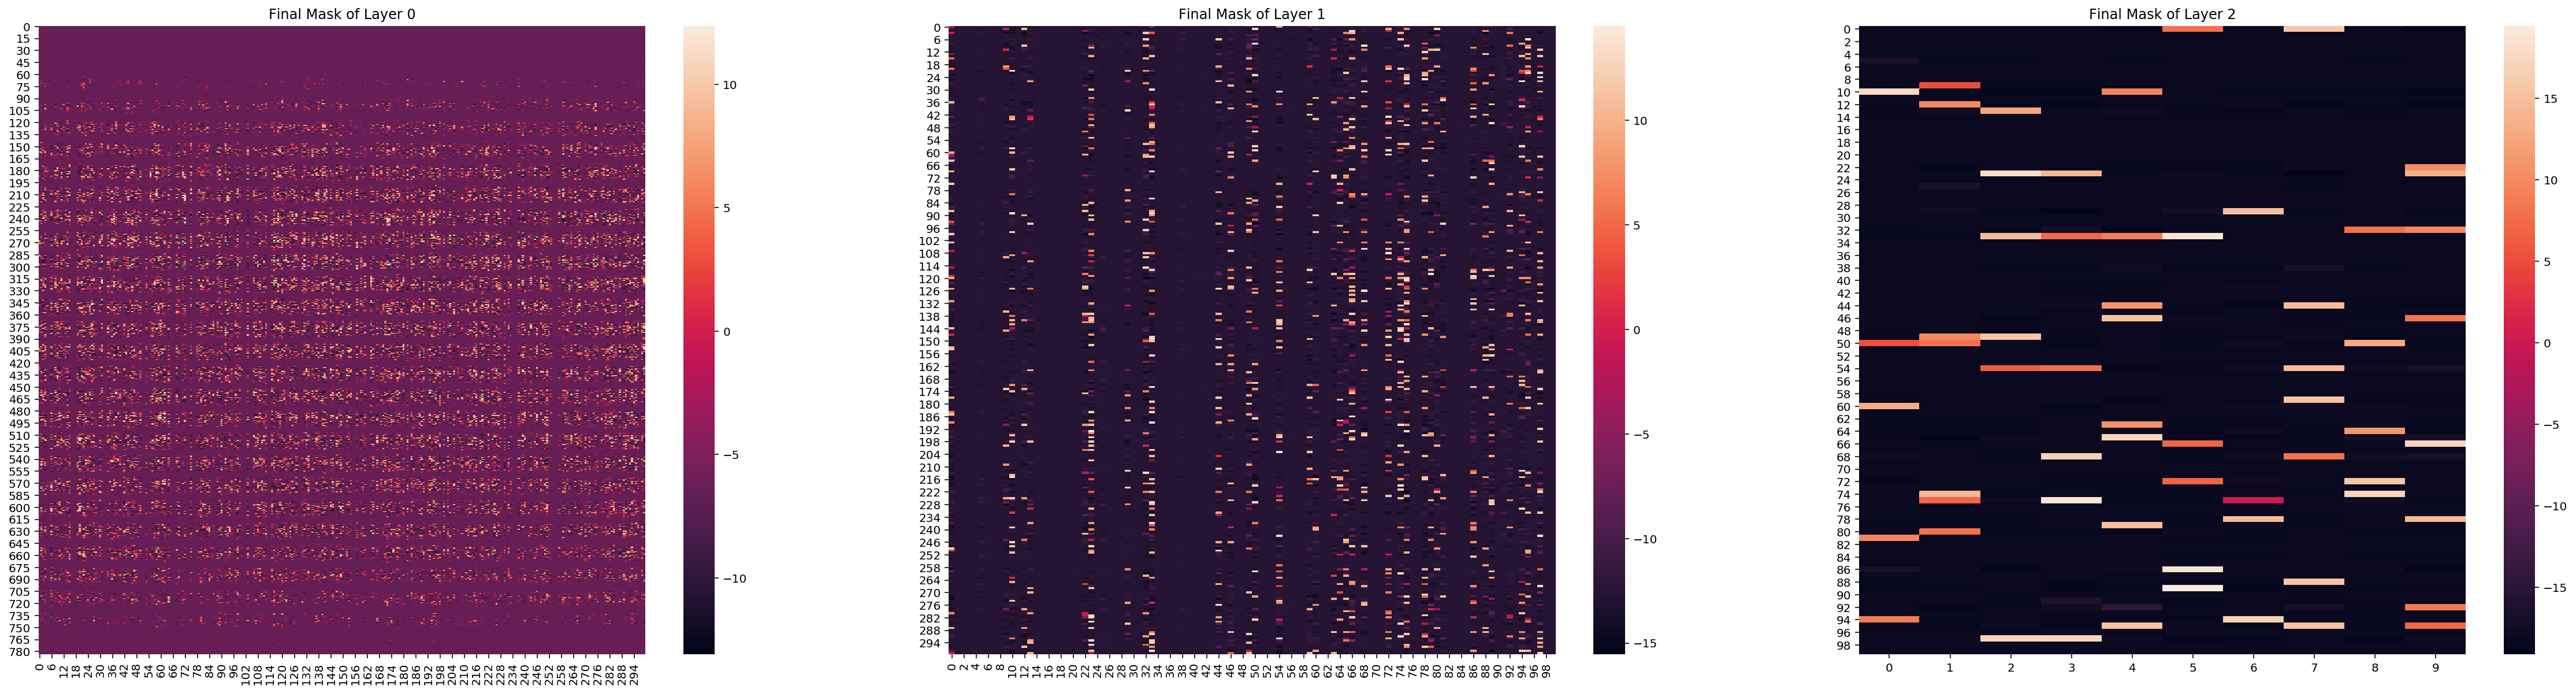

In [105]:
plt.figure(figsize=(40,10))
for layer in range(len(fcn_mask.trainable_weights)):
    plt.subplot(1,len(fcn_mask.trainable_weights),layer+1)
    mask = fcn_mask.layers[layer].mask.numpy()
    _ = sns.heatmap(mask, cbar=True)
    plt.title(f"Final Mask of Layer {layer}")
#sns.heatmap(fcn_mask.layers[0].mask.numpy())

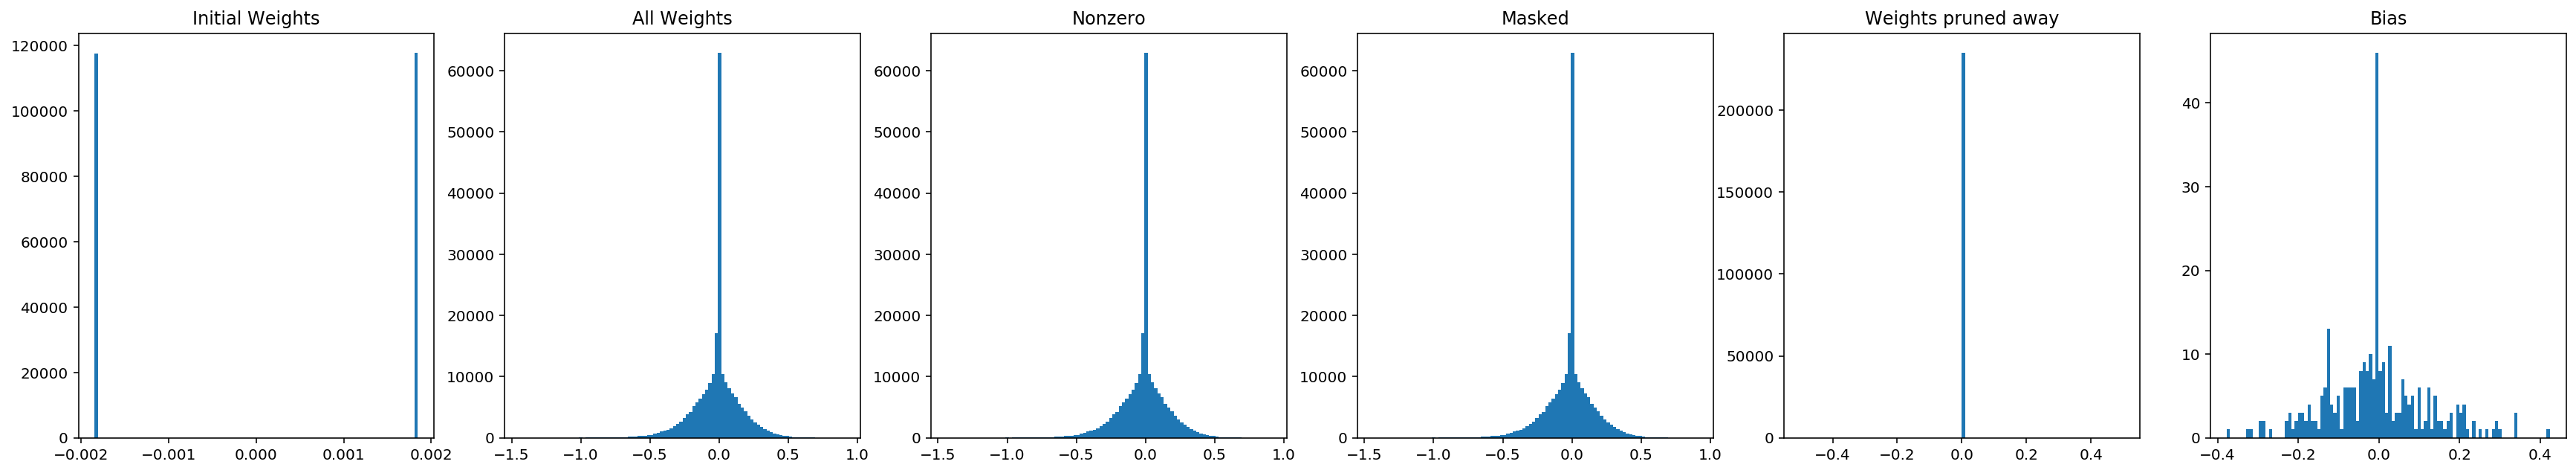

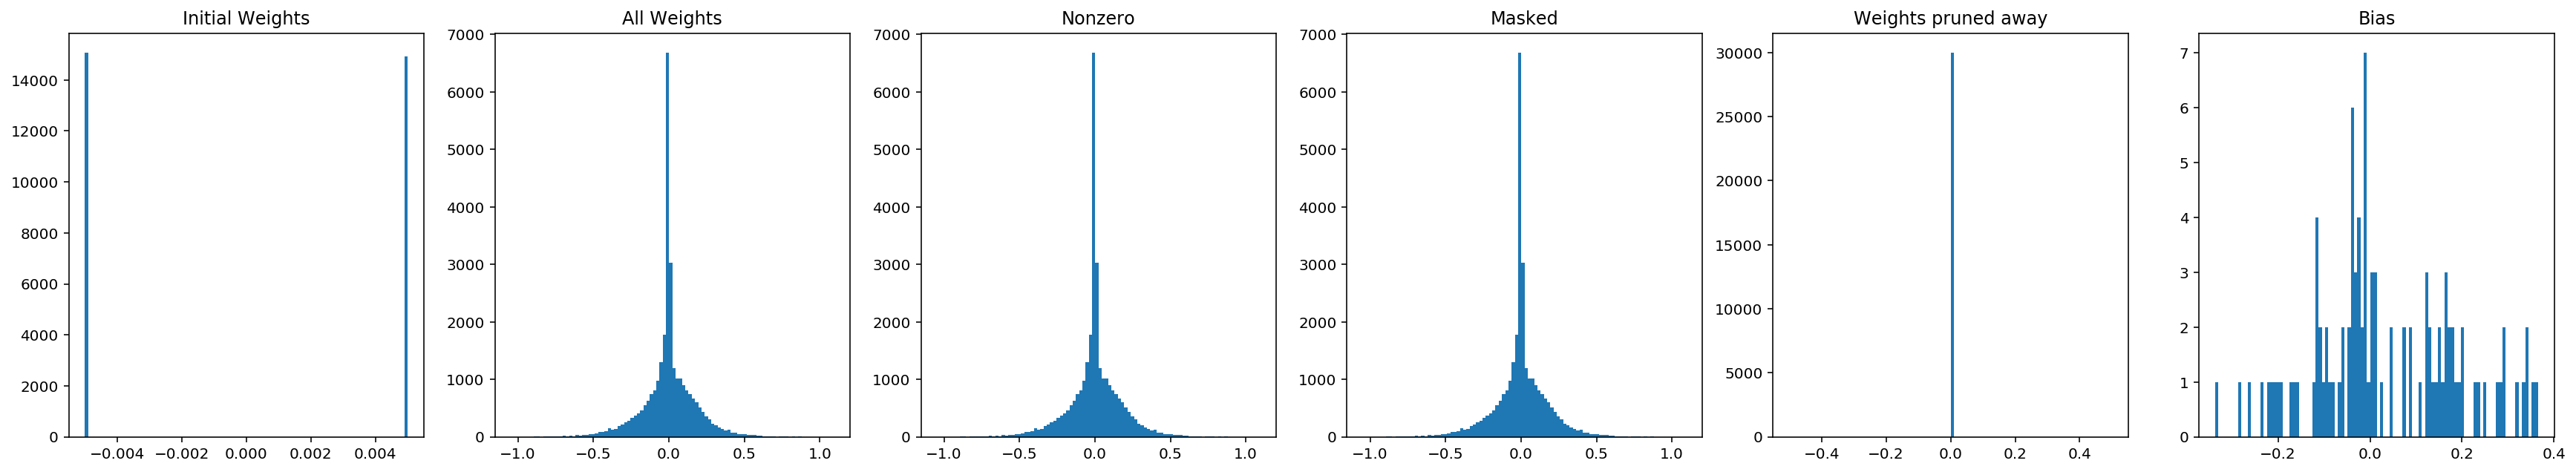

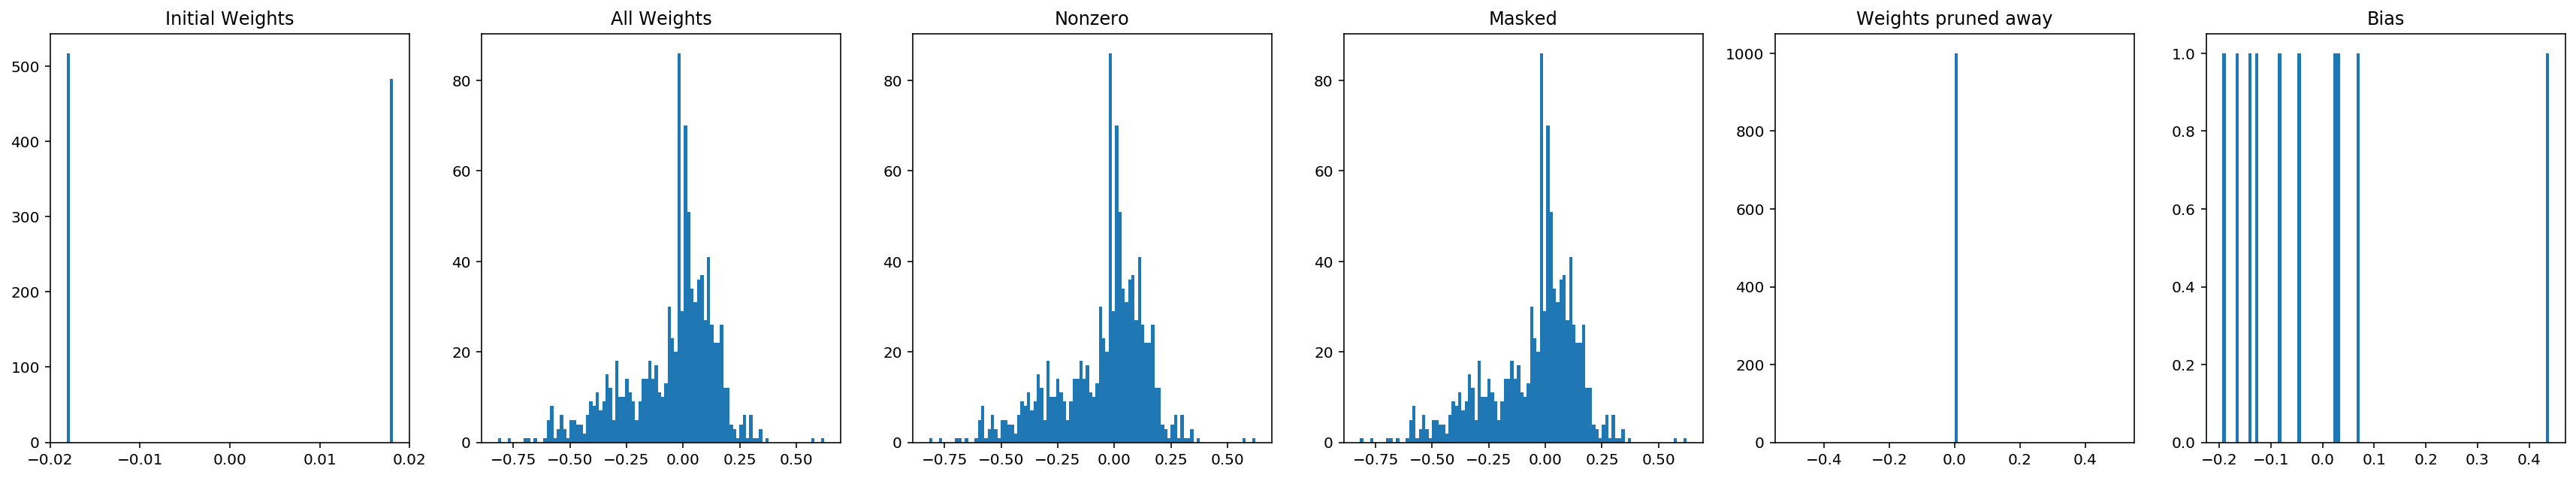

In [129]:
for i, layer in enumerate(fcn.layers):
    plt.figure(figsize=(30,5))
    plt.subplot(1,6,1)
    plt.title("Initial Weights")
    _ = plt.hist(initial_weights[i][0].flatten(), bins=100)
    plt.subplot(1,6,2)
    plt.title("All Weights")
    _ = plt.hist(layer.get_weights()[0].flatten(), bins=100)
    plt.subplot(1,6,3)
    plt.title("Nonzero")
    _ = plt.hist(layer.get_nonzero_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,4)
    plt.title("Masked")
    _ = plt.hist(layer.get_masked_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,5)
    plt.title("Weights pruned away")
    pruned_away = layer.get_pruned_weights().numpy().flatten()
    pruned_away_nonzero = pruned_away[np.nonzero(pruned_away)]
    _ = plt.hist(pruned_away_nonzero, bins=100)
    plt.subplot(1,6,6)
    plt.title("Bias")
    _ = plt.hist(layer.get_bias().numpy().flatten(), bins=100)

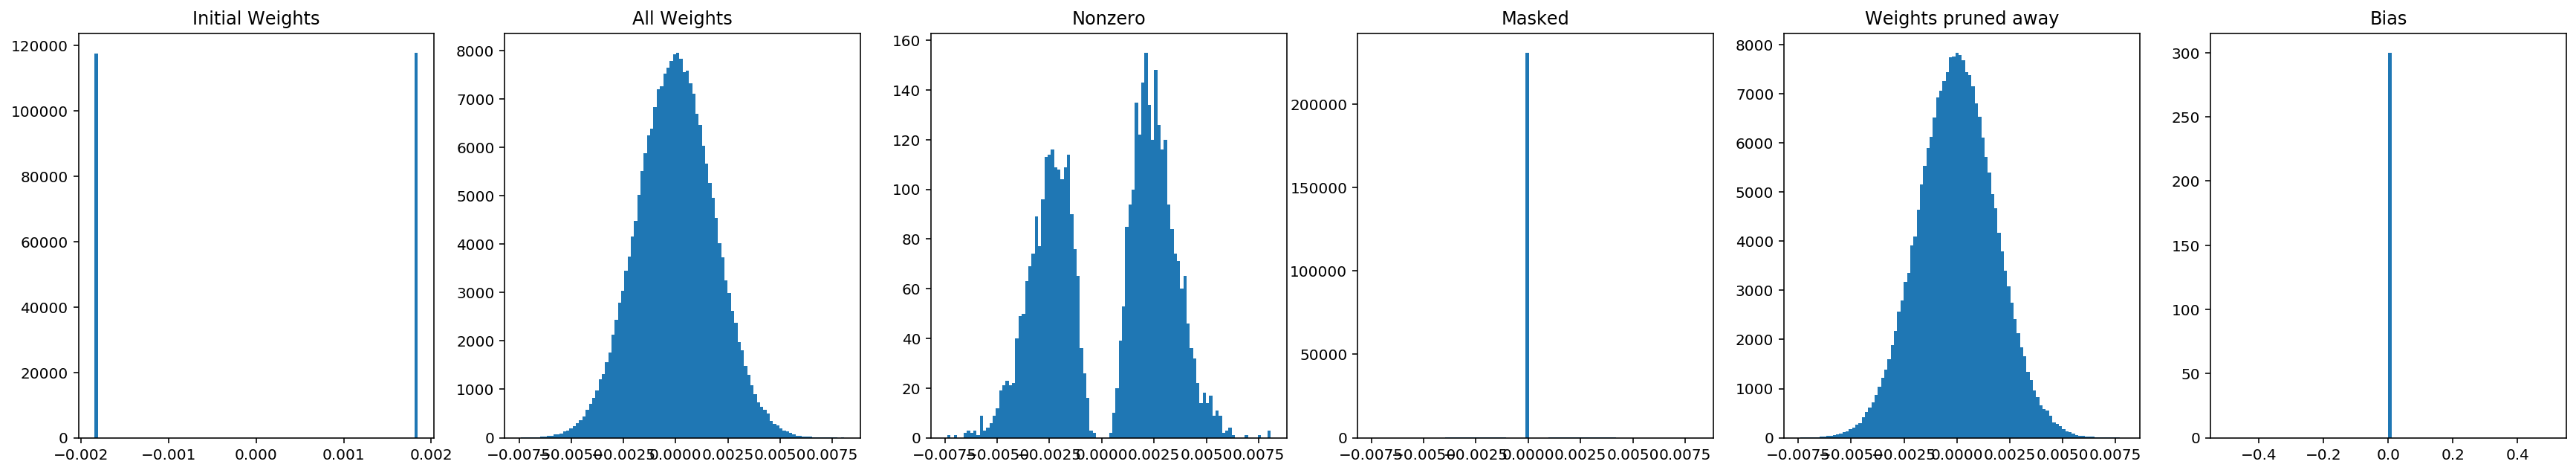

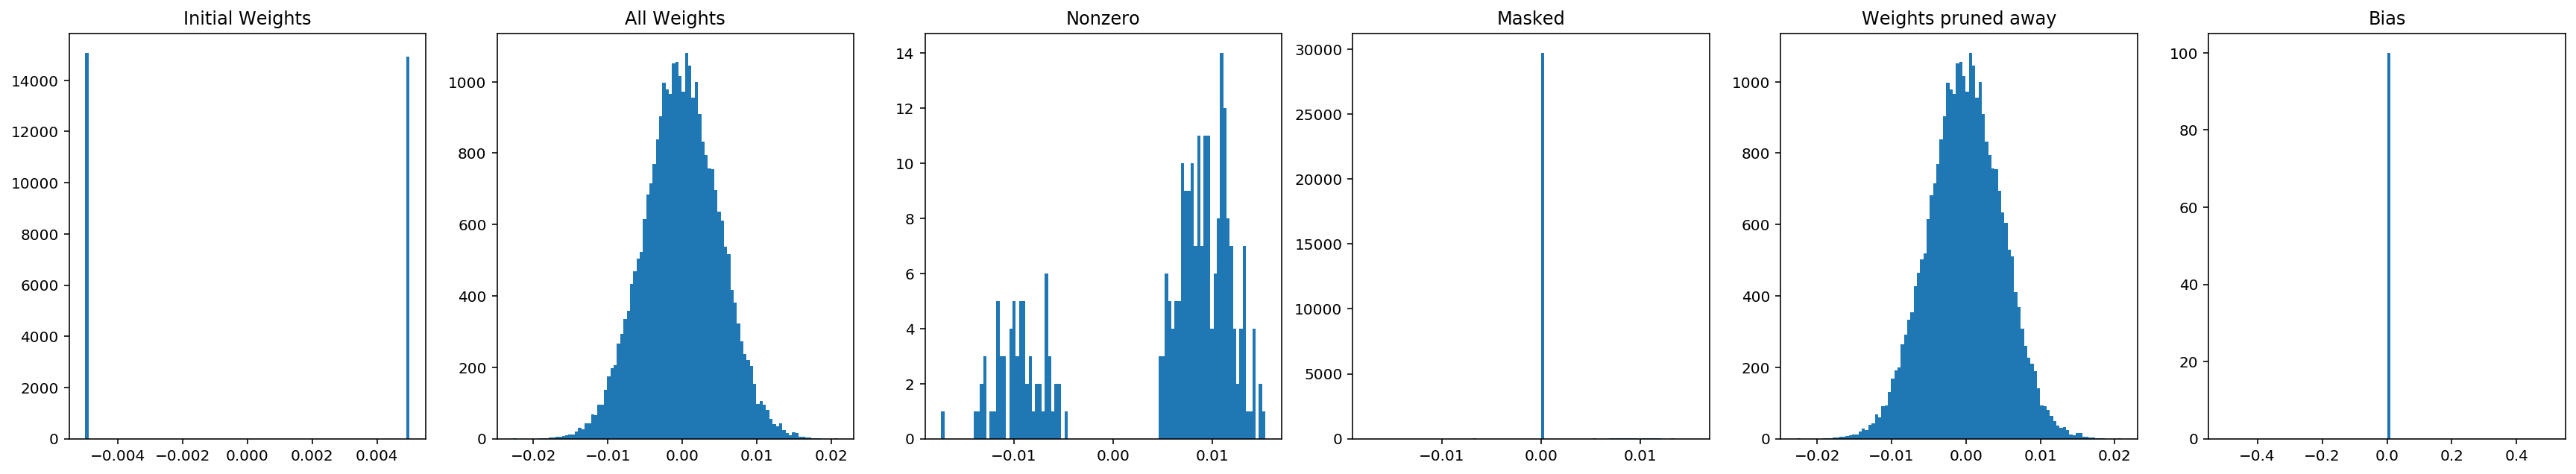

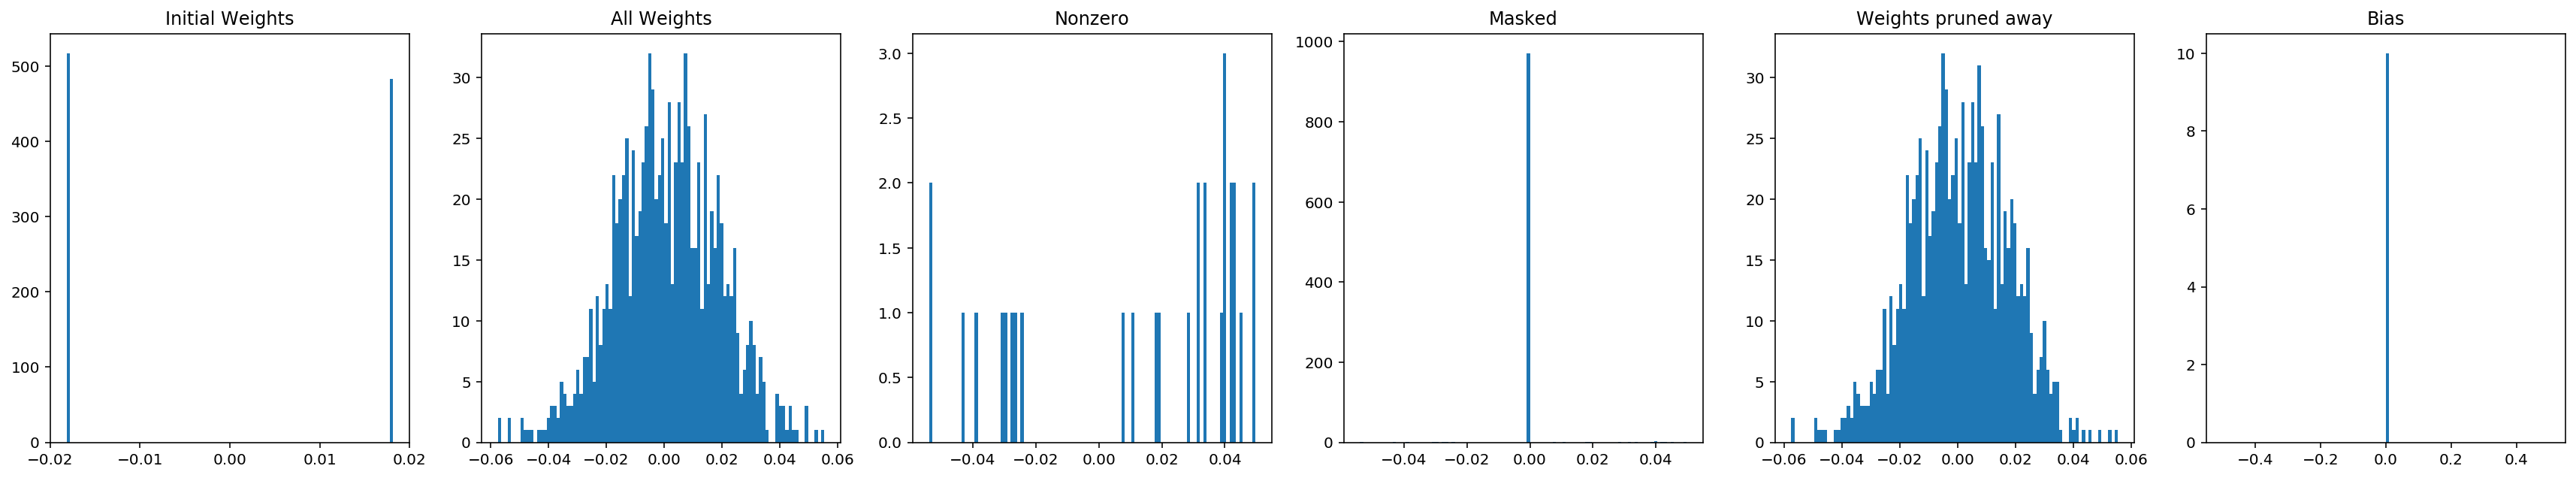

In [130]:
for i, layer in enumerate(fcn_mask.layers):
    plt.figure(figsize=(30,5))
    plt.subplot(1,6,1)
    plt.title("Initial Weights")
    _ = plt.hist(initial_weights[i][0].flatten(), bins=100)
    plt.subplot(1,6,2)
    plt.title("All Weights")
    _ = plt.hist(layer.get_normal_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,3)
    plt.title("Nonzero")
    _ = plt.hist(layer.get_nonzero_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,4)
    plt.title("Masked")
    _ = plt.hist(layer.get_masked_weights().numpy().flatten(), bins=100)
    plt.subplot(1,6,5)
    plt.title("Weights pruned away")
    pruned_away = layer.get_pruned_weights().numpy().flatten()
    pruned_away_nonzero = pruned_away[np.nonzero(pruned_away)]
    _ = plt.hist(pruned_away_nonzero, bins=100)
    plt.subplot(1,6,6)
    plt.title("Bias")
    _ = plt.hist(layer.get_bias().numpy().flatten(), bins=100)